#### IMPORTAR LIBRERÍAS Y FUNCIONES

In [18]:
# IMPORTAR LIBRERÍAS
from pathlib import Path # para establecer el path relativo
import sys
import os
import rasterio as rio # librería para trabajar con archivos tipo raster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler # para normalizar variables
import math
import matplotlib.colors as mcolors
from rasterio.transform import xy
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [19]:
# Agregar la ruta absoluta del directorio 'utils' al sys.path
utils_path = os.path.abspath(os.path.join(os.getcwd(), "src", "utils"))
# print("Ruta agregada al sys.path:", utils_path)  # Para verificar la ruta


# Importar las funciones desde funciones.py
from funciones import (
    cardinalidad,
    plot_frecuencias,
    variabilidad,
    plot_boxplots,
    plot_hist,
    app_mannwhitney)


#### CARGAR DATOS, ANÁLISIS PRELIMINAR DE LOS DATOS Y ORGANIZAR DATOS EN DF

##### A. Geotiff con los datos de segmentación (*Loss Big-Deltas*) de la señal espectral multitemporal

In [21]:
# Imagen de Big Deltas obtenida con el algoritmo de segmentación temporal LandTrend. La información en cada píxel (6 bandas) corresponde con el segmento 
# de magnitud mayor negativa (pérdida de valor del índice espectral) detectado en el modelo de ajuste de la serie temporal

# CARGAR LA IMAGEN
# crear ruta absoluta a la carpeta de imágenes
img_path = os.path.abspath(os.path.join(os.getcwd(), "src", "data"))
# print("Ruta hacia las imágenes:", img_path)  # Verificar la ruta

# Crear una ruta al archivo de la imagen
file_path = os.path.join(img_path, "LossBD_LT_ROI1_TCW.tif")
# print("Ruta de la imagen específica:", file_path) # Verificar la ruta

# Abrir y leer el archivo GeoTIFF
with rio.open(file_path) as src_img:
    meta = src_img.meta # metadatos básicos del archivo de la imagen
    band_count = src_img.count  # número de bandas de la imagen
    width, height = src_img.width, src_img.height # ancho y alto de la imagen en píxeles
    crs = src_img.crs # sistema de referencia de coordenadas de la imagen para WGS 84
    transform = src_img.transform # matriz de transformación que permite conversión entre las coordenadas del píxel (x, y en la grilla) y las coordenadas espaciales (longitud/latitud o UTM).
    # bucle con compresión de lista para Leer y guardar la información de las bandas en un array de numpy
    bands_data = [src_img.read(i + 1) for i in range(band_count)] # Lista con los array (matrices) de np con los valores de las 6 bandas. Read(i + 1) porque en rasterio, las bandas comienzan en 1, no en 0

# Mostrar metadatos
print("Metadatos del GeoTIFF:")
print(f"Bandas: {band_count}")
print(f"Dimensiones: {width} x {height}")
print(f"CRS: {crs}")
# print(f"Transformación: {transform}")


Metadatos del GeoTIFF:
Bandas: 6
Dimensiones: 3946 x 3694
CRS: EPSG:4326


In [22]:
# ANÁLISIS PRELIMINAR de las bandas (como arrays de np dentro de la lista bands_data) - ANÁLISIS NAN

nan_stats = []

# Recorrer cada array en la lista
for idx, array in enumerate(bands_data):
    # Contar el número de valores NaN en el array
    num_nans = np.count_nonzero(np.isnan(array))
    
    # Calcular el porcentaje de NaN respecto al total de elementos
    total_elements = array.size
    perc_nans = (num_nans / total_elements) * 100
    
    # Almacenar los resultados en la lista
    nan_stats.append({
        'array_index': idx,
        'num_nans': num_nans,
        'perc_nans': perc_nans
    })

# Mostrar los resultados
for stats in nan_stats:
    print(f"Array en banda {stats['array_index']+1}:")
    print(f"  Número de NaNs: {stats['num_nans']}")
    print(f"  Porcentaje de NaNs: {stats['perc_nans']:.2f}%\n")

Array en banda 1:
  Número de NaNs: 12949552
  Porcentaje de NaNs: 88.84%

Array en banda 2:
  Número de NaNs: 12949552
  Porcentaje de NaNs: 88.84%

Array en banda 3:
  Número de NaNs: 12949552
  Porcentaje de NaNs: 88.84%

Array en banda 4:
  Número de NaNs: 12949552
  Porcentaje de NaNs: 88.84%

Array en banda 5:
  Número de NaNs: 12949552
  Porcentaje de NaNs: 88.84%

Array en banda 6:
  Número de NaNs: 12949552
  Porcentaje de NaNs: 88.84%



In [23]:
# ESTADÍSTICAS BÁSICAS para cada banda sin considerar los valores nan
band_stats = []
for i, band in enumerate(bands_data, 1):
    band_stats.append({
        "Banda": i,
        "Mínimo": np.nanmin(band),
        "Máximo": np.nanmax(band),
        "Promedio": np.nanmean(band),
        "Media": np.nanmedian(band),
        "Desviación estándar": np.nanstd(band)
    })

band_stats

[{'Banda': 1,
  'Mínimo': 2001.0,
  'Máximo': 2021.0,
  'Promedio': 2011.3605888730722,
  'Media': 2011.0,
  'Desviación estándar': 5.908742474173405},
 {'Banda': 2,
  'Mínimo': 0.00032230195381544036,
  'Máximo': 4858.092099999998,
  'Promedio': 674.0571094444131,
  'Media': 613.9526775668229,
  'Desviación estándar': 430.99183201982686},
 {'Banda': 3,
  'Mínimo': 1.0,
  'Máximo': 23.0,
  'Promedio': 2.8708668618759265,
  'Media': 1.0,
  'Desviación estándar': 4.538326464130636},
 {'Banda': 4,
  'Mínimo': -2705.4152999999997,
  'Máximo': 5500.007499999998,
  'Promedio': -592.3207378264559,
  'Media': -572.1392919625198,
  'Desviación estándar': 175.87953538714996},
 {'Banda': 5,
  'Mínimo': 1.4650088809792743e-05,
  'Máximo': 4858.092099999998,
  'Promedio': 587.7883269579886,
  'Media': 508.6455404494151,
  'Desviación estándar': 465.976190108811},
 {'Banda': 6,
  'Mínimo': 7.026984073532354e-06,
  'Máximo': 79.60781590627441,
  'Promedio': 8.15233464612839,
  'Media': 6.940889294265

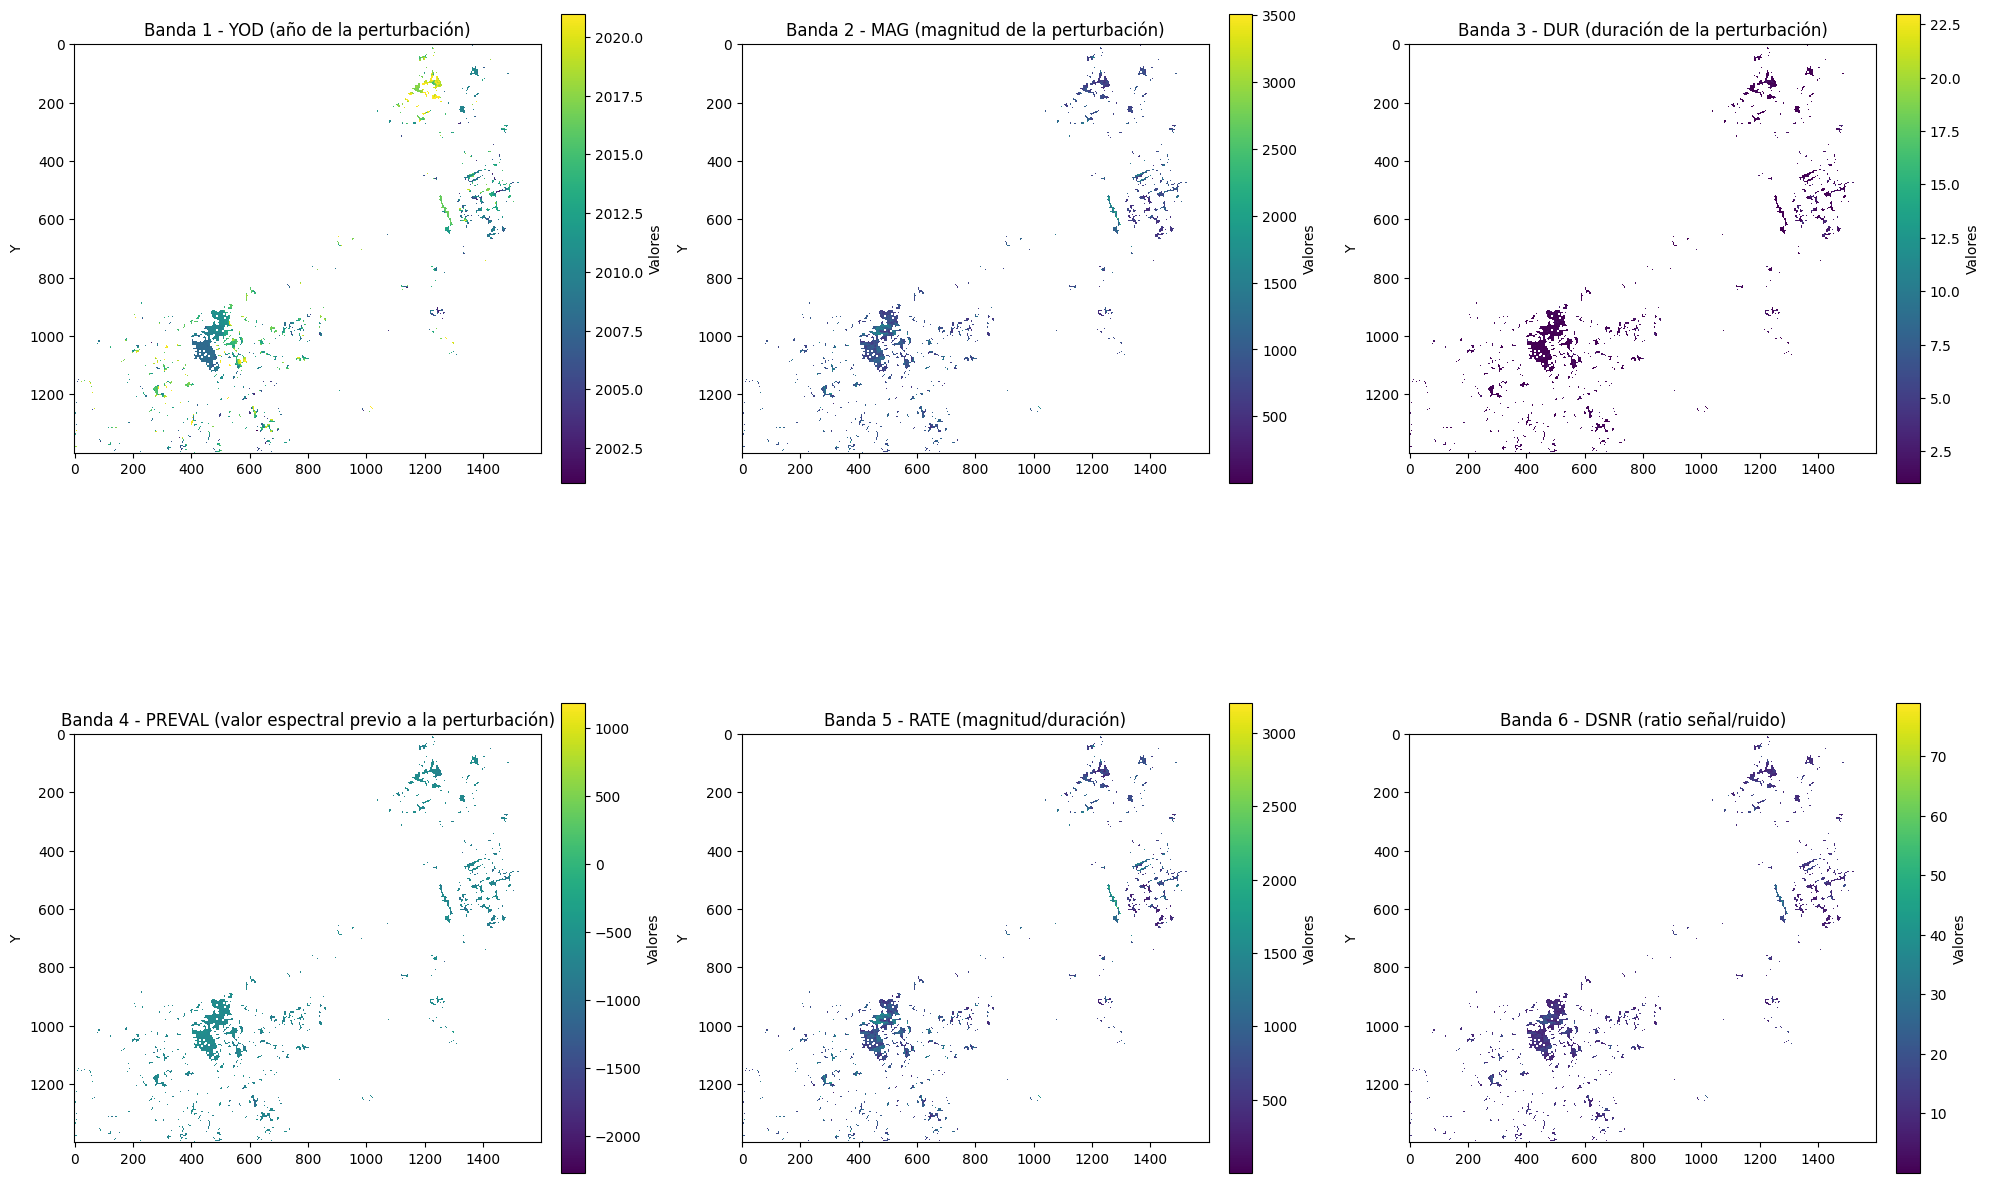

In [24]:
# VISUALIZAR Y EXTRAER LAS BANDAS

# Definir los rangos de slicing como variables
x_min, x_max = 1500, 3100  # Rango en X (columnas)
y_min, y_max = 400, 1800   # Rango en Y (filas)

# Crear la figura y subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 15))  # 2 filas y 3 columnas para las 6 bandas

# Nombres para cada banda
titles = ["Banda 1 - YOD (año de la perturbación)", "Banda 2 - MAG (magnitud de la perturbación)", "Banda 3 - DUR (duración de la perturbación)",
          "Banda 4 - PREVAL (valor espectral previo a la perturbación)", "Banda 5 - RATE (magnitud/duración)", "Banda 6 - DSNR (ratio señal/ruido)"]

# Recorrer las bandas y asignarlas a subplots
for i, ax in enumerate(axes.flat):
    # Seleccionar la banda correspondiente
    band = bands_data[i]
    
    # Visualizar con imshow
    im = ax.imshow(band[y_min:y_max, x_min:x_max], cmap='viridis') # se aplica slicing para visualizar los valores no NaN que están "centrados" en la imagen
    ax.set_title(titles[i])  # Agregar título
    # ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    # Barra de color para cada subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Valores")
    
    # Ajustar barra de color a los valores min y máx de la visualización
    vmin = np.nanmin(band[y_min:y_max, x_min:x_max])  # Ignorar NaN en los cálculos
    vmax = np.nanmax(band[y_min:y_max, x_min:x_max])
    cbar.ax.set_ylim(vmin, vmax)  # Ajustar límites

# Ajustar diseño para evitar superposiciones
plt.tight_layout()
plt.show()


# Extraer bandas las 6 bandas
band_1_yod = bands_data[0]
band_2_mag = bands_data[1]
band_3_dur = bands_data[2]
band_4_preval = bands_data[3]
band_5_rate = bands_data[4]
band_6_dsnr = bands_data[5]



In [25]:
# CREAR UN DATAFRAME CON LA POSICIÓN DE LOS PÍXELES E INFORMACIÓN DE LAS BANDAS

# crear diccionario con los datos de las bandas. Se usa el flatten para pasar de un array de dos dimensiones a una única dimensión
data = {
    "Band_1_YOD": bands_data[0].flatten(),
    "Band_2_MAG": bands_data[1].flatten(),
    "Band_3_DUR": bands_data[2].flatten(),
    "Band_4_PREVAL": bands_data[3].flatten(),
    "Band_5_RATE": bands_data[4].flatten(),
    "Band_6_DSNR": bands_data[5].flatten(),
}

data

{'Band_1_YOD': array([nan, nan, nan, ..., nan, nan, nan]),
 'Band_2_MAG': array([nan, nan, nan, ..., nan, nan, nan]),
 'Band_3_DUR': array([nan, nan, nan, ..., nan, nan, nan]),
 'Band_4_PREVAL': array([nan, nan, nan, ..., nan, nan, nan]),
 'Band_5_RATE': array([nan, nan, nan, ..., nan, nan, nan]),
 'Band_6_DSNR': array([nan, nan, nan, ..., nan, nan, nan])}

In [26]:
# Incluir las coordenadas de los píxeles en el df

# Obtener dimensiones de la banda (todas tienen las mismas dimensiones)
n_rows, n_cols = bands_data[0].shape

# Crear los grids de índices de píxeles
x_coords = np.arange(1, n_cols+1) # crear array de posiciones de los píxeles en x
y_coords = np.arange(1, n_rows+1) # crear array de posiciones de los píxeles en y
x_grid, y_grid = np.meshgrid(x_coords, y_coords) 

# Convertir índices de píxel (X, Y) a coordenadas espaciales geográficas (long, lat)
transform = meta['transform']  # Transformación del archivo raster
x_spatial, y_spatial = xy(transform, y_grid, x_grid, offset='center')
# Convertir las coordenadas espaciales (x_spatial, y_spatial) a arrays de Numpy
x_spatial = np.array(x_spatial)  # Convertir lista a array
y_spatial = np.array(y_spatial)  # Convertir lista a array

# Aplanar para incluir en el DataFrame
data["X"] = x_grid.flatten()  # Coordenadas en índice de píxel (columnas)
data["Y"] = y_grid.flatten()  # Coordenadas en índice de píxel (filas)
data["long"] = x_spatial.flatten()  # Coordenadas geográficas (longitud)
data["lat"] = y_spatial.flatten()  # Coordenadas geográficas (latitud)

In [27]:
# Crear el df con la información de la imagen con los datos de segmentación
df = pd.DataFrame(data)
df.dropna().describe()

,Band_1_YOD,Band_2_MAG,Band_3_DUR,Band_4_PREVAL,Band_5_RATE,Band_6_DSNR,X,Y,long,lat
count,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06,1.626972e+06
mean,2.011361e+03,6.740571e+02,2.870867e+00,-5.923207e+02,5.877883e+02,8.152335e+00,1.502179e+03,2.004662e+03,-7.513329e+01,-8.582368e+00
std,5.908744e+00,4.309920e+02,4.538328e+00,1.758796e+02,4.659763e+02,5.418322e+00,8.008441e+02,7.181131e+02,2.158231e-01,1.935276e-01
min,2.001000e+03,3.223020e-04,1.000000e+00,-2.705415e+03,1.465009e-05,7.026984e-06,1.600000e+01,6.500000e+01,-7.553381e+01,-9.036019e+00
25%,2.006000e+03,3.281949e+02,1.000000e+00,-6.584671e+02,1.835858e+02,4.537038e+00,8.840000e+02,1.547000e+03,-7.529989e+01,-8.736071e+00
50%,2.011000e+03,6.139527e+02,1.000000e+00,-5.721393e+02,5.086455e+02,6.940889e+00,1.422000e+03,2.080000e+03,-7.515490e+01,-8.602671e+00
75%,2.017000e+03,9.579141e+02,2.000000e+00,-4.998661e+02,9.085664e+02,1.046762e+01,1.970000e+03,2.575000e+03,-7.500722e+01,-8.459031e+00
max,2.021000e+03,4.858092e+03,2.300000e+01,5.500007e+03,4.858092e+03,7.960782e+01,3.934000e+03,3.688000e+03,-7.447793e+01,-8.059640e+00


In [28]:
df.sample(2)

,Band_1_YOD,Band_2_MAG,Band_3_DUR,Band_4_PREVAL,Band_5_RATE,Band_6_DSNR,X,Y,long,lat
11989330,NaN,NaN,NaN,NaN,NaN,NaN,1383,3039,-75.165409,-8.861117
256103,NaN,NaN,NaN,NaN,NaN,NaN,3560,65,-74.578719,-8.059640


In [29]:
df.X.value_counts() # validar la dimensión en X

X
1       3694
2621    3694
2623    3694
2624    3694
2625    3694
        ... 
1321    3694
1322    3694
1323    3694
1324    3694
3946    3694
Name: count, Length: 3946, dtype: int64

In [30]:
df.Y.value_counts() # validar la dimensión en Y

Y
1       3946
2454    3946
2456    3946
2457    3946
2458    3946
        ... 
1236    3946
1237    3946
1238    3946
1239    3946
3694    3946
Name: count, Length: 3694, dtype: int64

In [31]:
# Revalidar número de nulos
df.isna().sum()

Band_1_YOD       12949552
Band_2_MAG       12949552
Band_3_DUR       12949552
Band_4_PREVAL    12949552
Band_5_RATE      12949552
Band_6_DSNR      12949552
X                       0
Y                       0
long                    0
lat                     0
dtype: int64

##### B. Geotiff con los datos de referencia: clasificación de los píxeles como No deforestado (1) o deforestado (2)

In [32]:
# Cargar los archivos de las imágenes con los DATOS DE REFERENCIA
# Dataset Global Forest Cover, donde se identifican las áreas deforestadas y no deforestadas para el periodo 2001 - 2021


# crear ruta absoluta a la carpeta de imágenes
img_path = os.path.abspath(os.path.join(os.getcwd(), "src", "data"))
# print("Ruta hacia las imágenes:", img_path)  # Verificar la ruta

# Crear una ruta al archivo de la imagen
file_path = os.path.join(img_path, "GT_DF_class_GFC_ROI1.tif")
# print("Ruta de la imagen específica:", file_path) # Verificar la ruta

# Abrir y leer el archivo GeoTIFF
with rio.open(file_path) as src_ref:
    meta = src_ref.meta # metadatos básicos del archivo de la imagen
    band_count = src_ref.count  # número de bandas de la imagen
    width, height = src_ref.width, src_ref.height # ancho y alto de la imagen en píxeles
    crs = src_ref.crs # sistema de referencia de coordenadas de la imagen para WGS 84
    transform = src_ref.transform # matriz de transformación que permite conversión entre las coordenadas del píxel (x, y en la grilla) y las coordenadas espaciales (longitud/latitud o UTM).
    # bucle con compresión de lista para Leer y guardar la información de las bandas en un array de numpy
    bands_data = [src_ref.read(i + 1) for i in range(band_count)] # read(i + 1) porque en rasterio, las bandas comienzan en 1, no en 0

# Mostrar metadatos
print("Metadatos del GeoTIFF:")
print(f"Bandas: {band_count}")
print(f"Dimensiones: {width} x {height}")
print(f"CRS: {crs}")
# print(f"Transformación: {transform}")

Metadatos del GeoTIFF:
Bandas: 1
Dimensiones: 3946 x 3694
CRS: EPSG:4326


In [33]:
# Contar el número de valores NaN en la banda 1
num_nans = np.count_nonzero(np.isnan(bands_data[0]))
num_nans

11803471

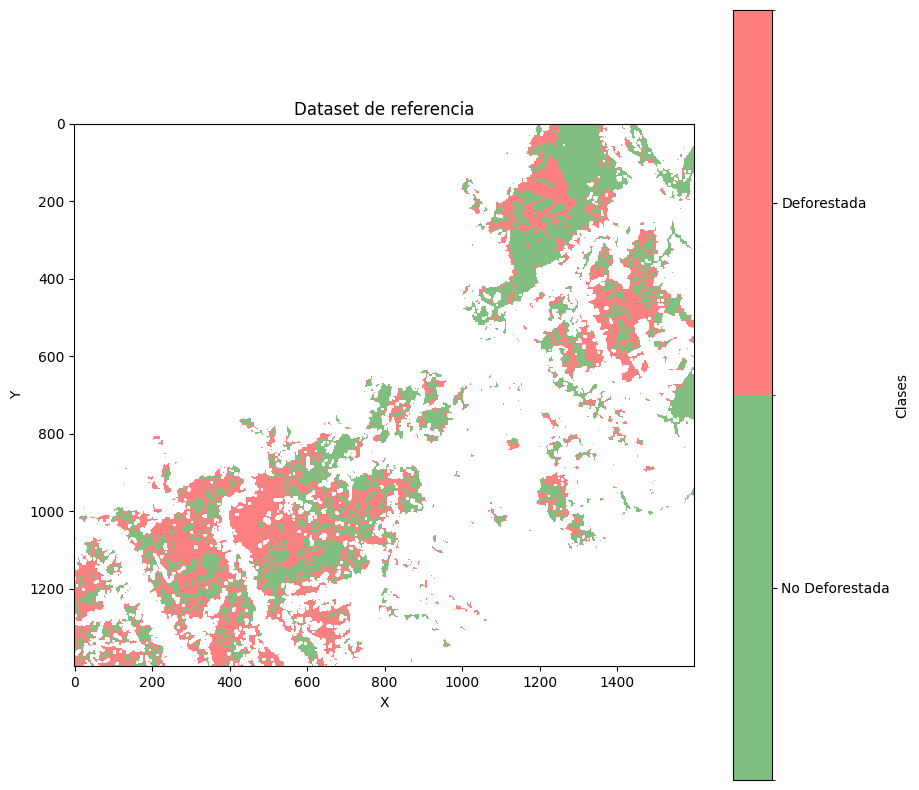

In [34]:
# VISUALIZAR LA BANDA CON LOS DATOS DE REFERENCIA 

# Definir la banda
band_ref = bands_data[0]

# Color map personalizado
cmap = mcolors.ListedColormap(['green', 'red'])  # Crear un colormap personalizado para dos clases (1 y 2)
bounds = [0.5, 1.5, 2.5]  # Establecer límites para cada clase
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalizar el colormap

# Visualizar la banda de referencia
plt.figure(figsize=(10, 10))

im_ref = plt.imshow(band_ref[y_min:y_max, x_min:x_max], cmap=cmap, norm=norm,alpha=0.5)  # Aplicar colormap y normalización
plt.title('Dataset de referencia')
plt.xlabel("X")
plt.ylabel("Y")

# Barra de color con etiquetas personalizadas
cbar = plt.colorbar(im_ref, ticks=[1, 2])  # Mostrar solo los valores 1 y 2
cbar.set_label("Clases")
cbar.ax.set_yticklabels(['No Deforestada', 'Deforestada'])  # Etiquetas personalizadas para las clases

plt.show()

In [35]:
# CREAR UN DATAFRAME CON LA POSICIÓN DE LOS PÍXELES Y LOS DATOS DE REFERENCIA

# crear diccionario con la información de la banda. Se usa el flatten para pasar de un array de dos dimensiones a una única dimensión
data_ref = {
    "Clasificacion": band_ref.flatten(),}

# Obtener dimensiones de la banda
n_rows, n_cols = bands_data[0].shape

# Crear los grids de índices de píxeles
x_coords = np.arange(1, n_cols+1) # crear array de posiciones de los píxeles en x
y_coords = np.arange(1, n_rows+1) # crear array de posiciones de los píxeles en y
x_grid, y_grid = np.meshgrid(x_coords, y_coords) 

# Convertir índices de píxel (X, Y) a coordenadas espaciales geográficas (long, lat)
transform = meta['transform']  # Transformación del archivo raster
x_spatial, y_spatial = xy(transform, y_grid, x_grid, offset='center')

# Convertir las coordenadas espaciales (x_spatial, y_spatial) a arrays de Numpy
x_spatial = np.array(x_spatial)  # Convertir lista a array
y_spatial = np.array(y_spatial)  # Convertir lista a array

# Aplanar para incluir en el DataFrame
data_ref["X"] = x_grid.flatten()  # Coordenadas en índice de píxel (columnas)
data_ref["Y"] = y_grid.flatten()  # Coordenadas en índice de píxel (filas)
data_ref["long"] = x_spatial.flatten()  # Coordenadas geográficas (longitud)
data_ref["lat"] = y_spatial.flatten()  # Coordenadas geográficas (latitud)

In [36]:
# Crear el df_ref
df_ref = pd.DataFrame(data_ref)
df_ref.dropna().describe()

,Clasificacion,X,Y,long,lat
count,2.773053e+06,2.773053e+06,2.773053e+06,2.773053e+06,2.773053e+06
mean,1.467114e+00,1.441350e+03,2.017357e+03,-7.514967e+01,-8.585796e+00
std,4.989174e-01,8.299340e+02,7.327535e+02,2.236627e-01,1.974731e-01
min,1.000000e+00,1.600000e+01,6.500000e+01,-7.553379e+01,-9.036025e+00
25%,1.000000e+00,7.980000e+02,1.573000e+03,-7.532305e+01,-8.738234e+00
50%,1.000000e+00,1.319000e+03,2.111000e+03,-7.518264e+01,-8.611032e+00
75%,2.000000e+00,1.909000e+03,2.583000e+03,-7.502364e+01,-8.466044e+00
max,2.000000e+00,3.934000e+03,3.688000e+03,-7.447791e+01,-8.059646e+00


In [37]:
df.X.value_counts() #validar la dimensión en X

X
1       3694
2621    3694
2623    3694
2624    3694
2625    3694
        ... 
1321    3694
1322    3694
1323    3694
1324    3694
3946    3694
Name: count, Length: 3946, dtype: int64

In [38]:
df.Y.value_counts() #validar la dimensión en Y

Y
1       3946
2454    3946
2456    3946
2457    3946
2458    3946
        ... 
1236    3946
1237    3946
1238    3946
1239    3946
3694    3946
Name: count, Length: 3694, dtype: int64

#### ETL DATAFRAME PARA EL ANÁLISIS

In [39]:
df_merge = pd.merge(df, df_ref, on=['X', 'Y'], how='outer')

In [40]:
df_merge.sample(2)

,Band_1_YOD,Band_2_MAG,Band_3_DUR,Band_4_PREVAL,Band_5_RATE,Band_6_DSNR,X,Y,long_x,lat_x,Clasificacion,long_y,lat_y
10322603,NaN,NaN,NaN,NaN,NaN,NaN,2795,1568,-74.784882,-8.46469,NaN,-74.784867,-8.464697
6804551,NaN,NaN,NaN,NaN,NaN,NaN,1843,204,-75.041441,-8.09710,NaN,-75.041426,-8.097106


In [41]:
# Revisar los valores por columnas sin NaN para saber el número de registros válidos con los que se cuenta
df_merge.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 1626967 entries, 58232 to 14529481
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Band_1_YOD     1626967 non-null  float64
 1   Band_2_MAG     1626967 non-null  float64
 2   Band_3_DUR     1626967 non-null  float64
 3   Band_4_PREVAL  1626967 non-null  float64
 4   Band_5_RATE    1626967 non-null  float64
 5   Band_6_DSNR    1626967 non-null  float64
 6   X              1626967 non-null  int32  
 7   Y              1626967 non-null  int32  
 8   long_x         1626967 non-null  float64
 9   lat_x          1626967 non-null  float64
 10  Clasificacion  1626967 non-null  float64
 11  long_y         1626967 non-null  float64
 12  lat_y          1626967 non-null  float64
dtypes: float64(11), int32(2)
memory usage: 161.4 MB


In [42]:
# ANALIZAR SI HAY VALORES DUMPLICADOS
print(f"Valores duplicados: {df_merge.duplicated().sum()}")

Valores duplicados: 0


In [43]:
# ANALIZAR POSIBLES DIFERENCIAS EN UBICACIÓN DE LOS PÍXELES DE LOS DOS DF QUE SE HAN UNIDO

# Calcular las diferencias absolutas entre las columnas.
df_merge['long_diff'] = (df_merge['long_x'] - df_merge['long_y']).abs()
df_merge['lat_diff'] = (df_merge['lat_x'] - df_merge['lat_y']).abs()

# Filtrar las filas donde las diferencias superan los umbrales. El umbral son los grados equivalentes al doble de la resolución espacial de la imagen (15 m)
long_mismatch = df_merge[df_merge['long_diff'] > 0.000273/2]
lat_mismatch = df_merge[df_merge['lat_diff'] > 0.00027/2]

# Mostrar los resultados
print(f"Número de registros con mismatch en longitud > {0.000273/2} grados: {len(long_mismatch)}")
print(f"Número de registros con mismatch en latitud > {0.00027/2} grados: {len(lat_mismatch)}")


Número de registros con mismatch en longitud > 0.0001365 grados: 0
Número de registros con mismatch en latitud > 0.000135 grados: 0


##### No hay registros con mismatch de localización con el dataset de referencia

In [44]:
# ANALIZAR LOS NAN
df_merge.isna().sum()/len(df_merge)*100

Band_1_YOD       88.838409
Band_2_MAG       88.838409
Band_3_DUR       88.838409
Band_4_PREVAL    88.838409
Band_5_RATE      88.838409
Band_6_DSNR      88.838409
X                 0.000000
Y                 0.000000
long_x            0.000000
lat_x             0.000000
Clasificacion    80.975897
long_y            0.000000
lat_y             0.000000
long_diff         0.000000
lat_diff          0.000000
dtype: float64

El % de NaN es muy alto porque corresponden con los píxeles de la imagen que están fuera del ROI (Region of Interest) del estudio. Píxeles fuera del área geográfica analizada y píxeles
donde el YOD del Big Delta está fuera del rango del periodo analizado: 2001-2021

Se elimiman los NaN porque corresponde con registros que están fuera del ROI (vallores enmascarados cuando se exportó la imagen desde GEE)

In [45]:
# Eliminamos valores NaN
df_cleaned = df_merge.copy().dropna()

In [46]:
# Confirmar que no hay valores nulos
df_cleaned.isna().sum()

Band_1_YOD       0
Band_2_MAG       0
Band_3_DUR       0
Band_4_PREVAL    0
Band_5_RATE      0
Band_6_DSNR      0
X                0
Y                0
long_x           0
lat_x            0
Clasificacion    0
long_y           0
lat_y            0
long_diff        0
lat_diff         0
dtype: int64

In [47]:
df_cleaned.info() # Información del df

<class 'pandas.core.frame.DataFrame'>
Index: 1626967 entries, 58232 to 14529481
Data columns (total 15 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Band_1_YOD     1626967 non-null  float64
 1   Band_2_MAG     1626967 non-null  float64
 2   Band_3_DUR     1626967 non-null  float64
 3   Band_4_PREVAL  1626967 non-null  float64
 4   Band_5_RATE    1626967 non-null  float64
 5   Band_6_DSNR    1626967 non-null  float64
 6   X              1626967 non-null  int32  
 7   Y              1626967 non-null  int32  
 8   long_x         1626967 non-null  float64
 9   lat_x          1626967 non-null  float64
 10  Clasificacion  1626967 non-null  float64
 11  long_y         1626967 non-null  float64
 12  lat_y          1626967 non-null  float64
 13  long_diff      1626967 non-null  float64
 14  lat_diff       1626967 non-null  float64
dtypes: float64(13), int32(2)
memory usage: 186.2 MB


Después de eliminar los NaN se cuenta con más de millón y medio de registros para el análisis

In [48]:
# Renombramos columnas con los nombres de las variables
df_cleaned.rename(columns={"Band_1_YOD":"yod",
                "Band_2_MAG":"mag",
                "Band_3_DUR":"dur",
                "Band_4_PREVAL":"preval",
                "Band_5_RATE":"rate",
                "Band_6_DSNR":"dsnr",
                "Band_1_YOD":"YOD",
                "Clasificacion":"clasificacion"},inplace=True)

# Forzar todas las columnas a minúsculas
df_cleaned.columns = df_cleaned.columns.str.lower()

df_cleaned.sample(10)

,yod,mag,dur,preval,rate,dsnr,x,y,long_x,lat_x,clasificacion,long_y,lat_y,long_diff,lat_diff
8386687,2008.0,310.638855,1.0,-457.994545,310.638855,5.535936,2271,1308,-74.926097,-8.394622,1.0,-74.926082,-8.394628,0.000015,0.000007
4020724,2015.0,900.987668,1.0,-445.605332,900.987668,8.210078,1089,1653,-75.244640,-8.487597,2.0,-75.244625,-8.487604,0.000015,0.000007
7866578,2006.0,1107.088038,1.0,-475.019962,1107.088038,15.711595,2130,2053,-74.964096,-8.595395,2.0,-74.964081,-8.595402,0.000015,0.000007
5920716,2001.0,950.573450,1.0,-536.211850,950.573450,5.515191,1603,2929,-75.106120,-8.831472,2.0,-75.106105,-8.831479,0.000015,0.000007
9900481,2017.0,946.203828,1.0,-544.458872,946.203828,12.440339,2681,562,-74.815605,-8.193579,2.0,-74.815590,-8.193585,0.000015,0.000007
915305,2015.0,437.823900,1.0,-546.210900,437.823900,6.959397,248,2888,-75.471285,-8.820423,2.0,-75.471270,-8.820430,0.000015,0.000007
1576100,2020.0,252.569170,2.0,-495.960058,126.284585,5.379455,427,2457,-75.423045,-8.704271,1.0,-75.423030,-8.704277,0.000015,0.000007
6156349,2009.0,772.957065,4.0,-484.044901,193.239266,6.893021,1667,2146,-75.088872,-8.620458,2.0,-75.088857,-8.620465,0.000015,0.000007
11825102,2006.0,226.317594,1.0,-950.130406,226.317594,3.490965,3202,609,-74.675198,-8.206245,1.0,-74.675183,-8.206251,0.000015,0.000007
4450455,2019.0,1239.705246,1.0,-627.466554,1239.705246,11.918217,1205,2880,-75.213379,-8.818267,2.0,-75.213364,-8.818274,0.000015,0.000007


In [49]:
# NORMALIZAR variables mag, preval y rate para que facilitar la comparabilidad entre variables

columns_to_normalize = ['mag', 'preval', 'rate']

scaler = MinMaxScaler() # definir el tipo de normalización
df_cleaned[[f"{col}_norm" for col in columns_to_normalize]] = scaler.fit_transform(df_cleaned[columns_to_normalize]) # aplicar normalización y crear columnas con los datos normalizados

df_cleaned.sample(10)

,yod,mag,dur,preval,rate,dsnr,x,y,long_x,lat_x,clasificacion,long_y,lat_y,long_diff,lat_diff,mag_norm,preval_norm,rate_norm
1089376,2010.0,777.845317,1.0,-466.535683,777.845317,3.939436,295,3341,-75.458619,-8.942504,2.0,-75.458604,-8.942511,0.000015,0.000007,0.160113,0.272854,0.160113
10824429,2002.0,635.589060,10.0,-552.267736,63.558906,8.728623,2931,1010,-74.748231,-8.314312,2.0,-74.748216,-8.314319,0.000015,0.000007,0.130831,0.262405,0.013083
6086839,2017.0,1293.710093,1.0,-563.394507,1293.710093,8.308888,1648,2822,-75.093992,-8.802636,2.0,-75.093978,-8.802643,0.000015,0.000007,0.266300,0.261049,0.266300
3327270,2006.0,234.559479,3.0,-515.916000,78.186493,6.225096,901,2671,-75.295305,-8.761943,1.0,-75.295290,-8.761949,0.000015,0.000007,0.048282,0.266836,0.016094
7881006,2013.0,901.048333,1.0,-989.776667,901.048333,5.930605,2134,1705,-74.963018,-8.501611,2.0,-74.963003,-8.501618,0.000015,0.000007,0.185474,0.209086,0.185474
2023701,2004.0,120.373982,5.0,-527.832100,24.074796,3.210500,548,3084,-75.390436,-8.873244,1.0,-75.390422,-8.873251,0.000015,0.000007,0.024778,0.265383,0.004956
7633716,2009.0,179.880550,9.0,-377.796422,19.986728,6.162770,2067,1913,-74.981074,-8.557666,1.0,-74.981059,-8.557672,0.000015,0.000007,0.037027,0.283668,0.004114
7744428,2008.0,494.271340,2.0,-685.490450,247.135670,6.421076,2097,1805,-74.972989,-8.528560,2.0,-74.972974,-8.528567,0.000015,0.000007,0.101742,0.246170,0.050871
1753433,2009.0,109.771360,15.0,-451.271100,7.318091,1.902775,475,2478,-75.410110,-8.709930,1.0,-75.410095,-8.709937,0.000015,0.000007,0.022596,0.274714,0.001506
2950784,2008.0,581.295676,1.0,-409.894024,581.295676,13.249486,799,2973,-75.322793,-8.843330,2.0,-75.322778,-8.843337,0.000015,0.000007,0.119655,0.279757,0.119655


In [50]:
# convertir valores de yod, dur y clasificacion a int

# Columnas a convertir de float a int
columns_to_convert = ['yod', 'dur', 'clasificacion']

# Convertir las columnas seleccionadas a int
df_cleaned[columns_to_convert] = df_cleaned[columns_to_convert].astype(int)

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1626967 entries, 58232 to 14529481
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   yod            1626967 non-null  int32  
 1   mag            1626967 non-null  float64
 2   dur            1626967 non-null  int32  
 3   preval         1626967 non-null  float64
 4   rate           1626967 non-null  float64
 5   dsnr           1626967 non-null  float64
 6   x              1626967 non-null  int32  
 7   y              1626967 non-null  int32  
 8   long_x         1626967 non-null  float64
 9   lat_x          1626967 non-null  float64
 10  clasificacion  1626967 non-null  int32  
 11  long_y         1626967 non-null  float64
 12  lat_y          1626967 non-null  float64
 13  long_diff      1626967 non-null  float64
 14  lat_diff       1626967 non-null  float64
 15  mag_norm       1626967 non-null  float64
 16  preval_norm    1626967 non-null  float64
 17  rate_nor

In [51]:
# Eliminar columnas que no se van a utilizar en los siguientes análisis para simplificar el df
df_final = df_cleaned.copy().drop(axis=1, columns=["mag","preval","rate","long_y","lat_y","long_y","lat_y","long_diff","lat_diff"])

df_final.sample(10)

,yod,dur,dsnr,x,y,long_x,lat_x,clasificacion,mag_norm,preval_norm,rate_norm
4678334,2021,1,6.997165,1267,1731,-75.196670,-8.508618,2,0.081005,0.236481,0.081005
1436629,2016,1,12.037253,389,3358,-75.433286,-8.947085,2,0.176394,0.245800,0.176394
3529480,2014,1,13.624511,956,1711,-75.280483,-8.503228,2,0.233872,0.270099,0.233872
2277878,2015,1,7.834878,617,2375,-75.371841,-8.682172,1,0.113540,0.246191,0.113540
10831263,2018,1,5.317051,2933,456,-74.747692,-8.165012,1,0.059096,0.259679,0.059096
1240550,2003,1,8.433247,336,3061,-75.447569,-8.867046,1,0.059972,0.266136,0.059972
2758765,2008,1,12.647387,747,3042,-75.336807,-8.861925,2,0.334653,0.253435,0.334653
5531742,2002,1,7.121695,1498,1825,-75.134417,-8.533950,2,0.185863,0.263539,0.185863
8176456,2002,2,10.255737,2214,1635,-74.941459,-8.482746,1,0.154025,0.260279,0.077013
11518028,2006,1,15.376676,3119,137,-74.697566,-8.079043,2,0.457875,0.376084,0.457875


In [52]:
df_final.rename(columns={"long_x":"long","lat_x":"lat"},inplace=True)

In [53]:
# crear una variable "clasificadion_desc" con etiquetas para los valores 1 y 2 del dataset de referencia
etiquetas = {
    1: "no deforestado",
    2: "deforestado"}

# Crear la nueva columna 'clasificacion_desc' mapeando los valores de 'clasificacion'
df_final['clasificacion_desc'] = df_final['clasificacion'].map(etiquetas)

In [54]:
df_final.sample(2)

,yod,dur,dsnr,x,y,long,lat,clasificacion,mag_norm,preval_norm,rate_norm,clasificacion_desc
4609014,2003,1,15.558381,1248,2597,-75.201790,-8.742000,2,0.153453,0.270674,0.153453,deforestado
3423210,2021,1,7.966326,927,2567,-75.288298,-8.733915,2,0.104803,0.268549,0.104803,deforestado


In [55]:
# copia del df listo para análisis
df = df_final.copy()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1626967 entries, 58232 to 14529481
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   yod                 1626967 non-null  int32  
 1   dur                 1626967 non-null  int32  
 2   dsnr                1626967 non-null  float64
 3   x                   1626967 non-null  int32  
 4   y                   1626967 non-null  int32  
 5   long                1626967 non-null  float64
 6   lat                 1626967 non-null  float64
 7   clasificacion       1626967 non-null  int32  
 8   mag_norm            1626967 non-null  float64
 9   preval_norm         1626967 non-null  float64
 10  rate_norm           1626967 non-null  float64
 11  clasificacion_desc  1626967 non-null  object 
dtypes: float64(6), int32(5), object(1)
memory usage: 130.3+ MB


#### ANÁLISIS DE LAS VARIABLES

##### Cardinalidad

In [57]:
# ANÁLISIS Y CLASIFICACIÓN DE LAS VARIABLES EN FUNCIÓN DE SU CARDINALIDAD
cardinalidad(df,10,30)

,valores_unicos,cardinalidad(%),tipo
yod,21,0.00,Numérica discreta
dur,23,0.00,Numérica discreta
dsnr,1598094,98.23,Numérica continua
x,3880,0.24,Numérica discreta
y,3622,0.22,Numérica discreta
long,3880,0.24,Numérica discreta
lat,3622,0.22,Numérica discreta
clasificacion,2,0.00,Binaria
mag_norm,1597992,98.22,Numérica continua
preval_norm,1596262,98.11,Numérica continua


#### Tabla de variables

|Columna/Variable|Descripción|Tipo_de_Variable|Rol en el EDA|Nota|
|-|-|-|-|-|
|x|Coordenada x de localización del píxel en la imagen|Numérica discreta|Define posición en x del píxel dentro de la imagen. Para que se pueda considerar como índice de los registros, habría que combinarla con los valores de y||
|y|Coordenada y de localización del píxel en la imagen|Numérica discreta|Define posición en y del píxel dentro de la imagen. Para que se pueda considerar como índice de los registros, habría que combinarla con los valores de x||
|long|Coordenada longitud de localización del píxel en la imagen|Numérica discreta|Define posición del píxel con coordenadas geográficas de longitud dentro del ROI||
|lat|Coordenada latitud de localización del píxel en la imagen|Numérica discreta|Define posición del píxel con coordenadas geográficas de latitud dentro del ROI||
|clasificación|Variable con los datos de referencia que indica si ha habido deforestación en el píxel|Categórica/Binaria|Variable directora del análisis|valor 1 = no deforestación, valor 2 = deforestación|
|mag_norm|Variable normalizada que representa la magnitud del cambio (negativo) en la señal espectral del píxel. La señal espectral se mide como el índice TCW que es sensible a los cambios en coberturas vegetales|Numérica continua|Esencial para identificar y caracterizar los cambios que podrían estar relacionados con eventos de deforestación||
|yod|Variable que indica el año en el que se ha producido un cambio negativo en la señal espectral|Numérica discreta|Importante para identificar los patrones temporales de deforestación del ROI (área de estudio)||
|dur|Variable que indica la duración del segemento que define al cambio negativo en la señal espectral|Numérica discreta|Esencial para identificar y caracterizar los cambios que podrían estar relacionados con eventos de deforestación (eventos de corta duración)||
|rate_norm|Variable normalizada que indica la tasa de cambio del segeento que se ajusta al cambio negativo en la señal espectral. Se calcula como mag/dur|Numérica continua|Importante para caracterizar los eventos de pérdida de cobertura vegetal y posibles causas de los mismos. Ej: Un evento de deforestación por incencio generalmente tiene tasas más altas que eventos de degradación de la cobertura vegetal graduales generados por tala ilegal||
|preval_norm|Variable normalizada que representa el valor de la señal espectral antes de producirse el cambio|Numérica continua|Indicador del verdor previo al evento de pérdida cobertura vegetal. Permite conocer el estado de la cobertura vegetal previa al evento||
|dsnr|Variable que representa la proporción de señal espectral frente al ruido espectral presente en la señal|Numérica continua|Importante para caracterizar la fiabilidad del modelo de segmentación. Valores bajos indican que la segmentación está fuertemente influenciada por el ruido espectral vs. cambios de señal espectral relacionados con eventos de pérdida de cobertura vegetal||

En la siguiente imagen se ilustran como se calculan las variables mag y dur en los segmentos a los que se ajusta la serie temporal de la señal espectral (índice espectral). La variable mag se calcula como la diferencia entre el valor del índice espectral entre el vértice final (*End value*) y el vértice inicial (*Start value*) de cada segmento. La duración como la diferencia de los años entre el año del vértice inicial (*Start year*) y el año del vértice final (*End year*).

<img src="./src/img/LT_output.png" alt="LT_output" style="width:50%; height:auto;">

Las variables yod y preval, se corresponden con el año y el valor de la señal espectral del vértice final del segmento (*End year* y *End value*)


In [58]:
# crear index a partir de los valores de x e y
df['xy'] = df['x'].astype(str) + " ; " + df['y'].astype(str)

cardinalidad(df,10,30)

,valores_unicos,cardinalidad(%),tipo
yod,21,0.00,Numérica discreta
dur,23,0.00,Numérica discreta
dsnr,1598094,98.23,Numérica continua
x,3880,0.24,Numérica discreta
y,3622,0.22,Numérica discreta
long,3880,0.24,Numérica discreta
lat,3622,0.22,Numérica discreta
clasificacion,2,0.00,Binaria
mag_norm,1597992,98.22,Numérica continua
preval_norm,1596262,98.11,Numérica continua


In [59]:
# con una cardinalidad del 100% se establece xy como el índice del df
df.set_index('xy', inplace=True)

In [60]:
df.sample(10)

,yod,dur,dsnr,x,y,long,lat,clasificacion,mag_norm,preval_norm,rate_norm,clasificacion_desc
xy,,,,,,,,,,,,
1675 ; 2208,2017,1,22.309014,1675,2208,-75.086716,-8.637167,2,0.340210,0.266027,0.340210,deforestado
1485 ; 1683,2002,1,6.649485,1485,1683,-75.137920,-8.495682,2,0.235441,0.269660,0.235441,deforestado
1594 ; 2677,2006,18,0.864462,1594,2677,-75.108545,-8.763560,1,0.008530,0.262335,0.000474,no deforestado
2158 ; 1361,2017,2,7.208701,2158,1361,-74.956550,-8.408905,2,0.182023,0.244936,0.091011,deforestado
1298 ; 2496,2021,1,4.789978,1298,2496,-75.188316,-8.714781,2,0.067571,0.263199,0.067571,deforestado
1456 ; 2664,2014,1,15.976504,1456,2664,-75.145735,-8.760056,2,0.180638,0.230480,0.180638,deforestado
2457 ; 1583,2018,6,5.995522,2457,1583,-74.875971,-8.468733,2,0.343125,0.326502,0.057187,deforestado
1156 ; 2184,2004,1,6.239491,1156,2184,-75.226584,-8.630699,1,0.070087,0.269422,0.070087,no deforestado
369 ; 2611,2013,1,9.468578,369,2611,-75.438676,-8.745773,2,0.153198,0.266135,0.153198,deforestado


#### ANÁLISIS UNIVARIANTE - Categóricas

In [61]:
# definir listas con variables categóricas y numéricas que voy a analizar de diferente forma
var_cat = ["clasificacion_desc"]
var_num = ["mag_norm","yod","dur","rate_norm","preval_norm","dsnr"]

In [62]:
# Frecuencias absolutas:
print(f"Frecuencias absolutas de la variable :\n{df[var_cat].value_counts()}\n")

# Frecuencias relativas: 
print(f"Frecuencias relativas de la variable :\n{df[var_cat].value_counts(normalize=True)*100}\n")

Frecuencias absolutas de la variable :
clasificacion_desc
deforestado           1069620
no deforestado         557347
Name: count, dtype: int64

Frecuencias relativas de la variable :
clasificacion_desc
deforestado           65.74319
no deforestado        34.25681
Name: proportion, dtype: float64



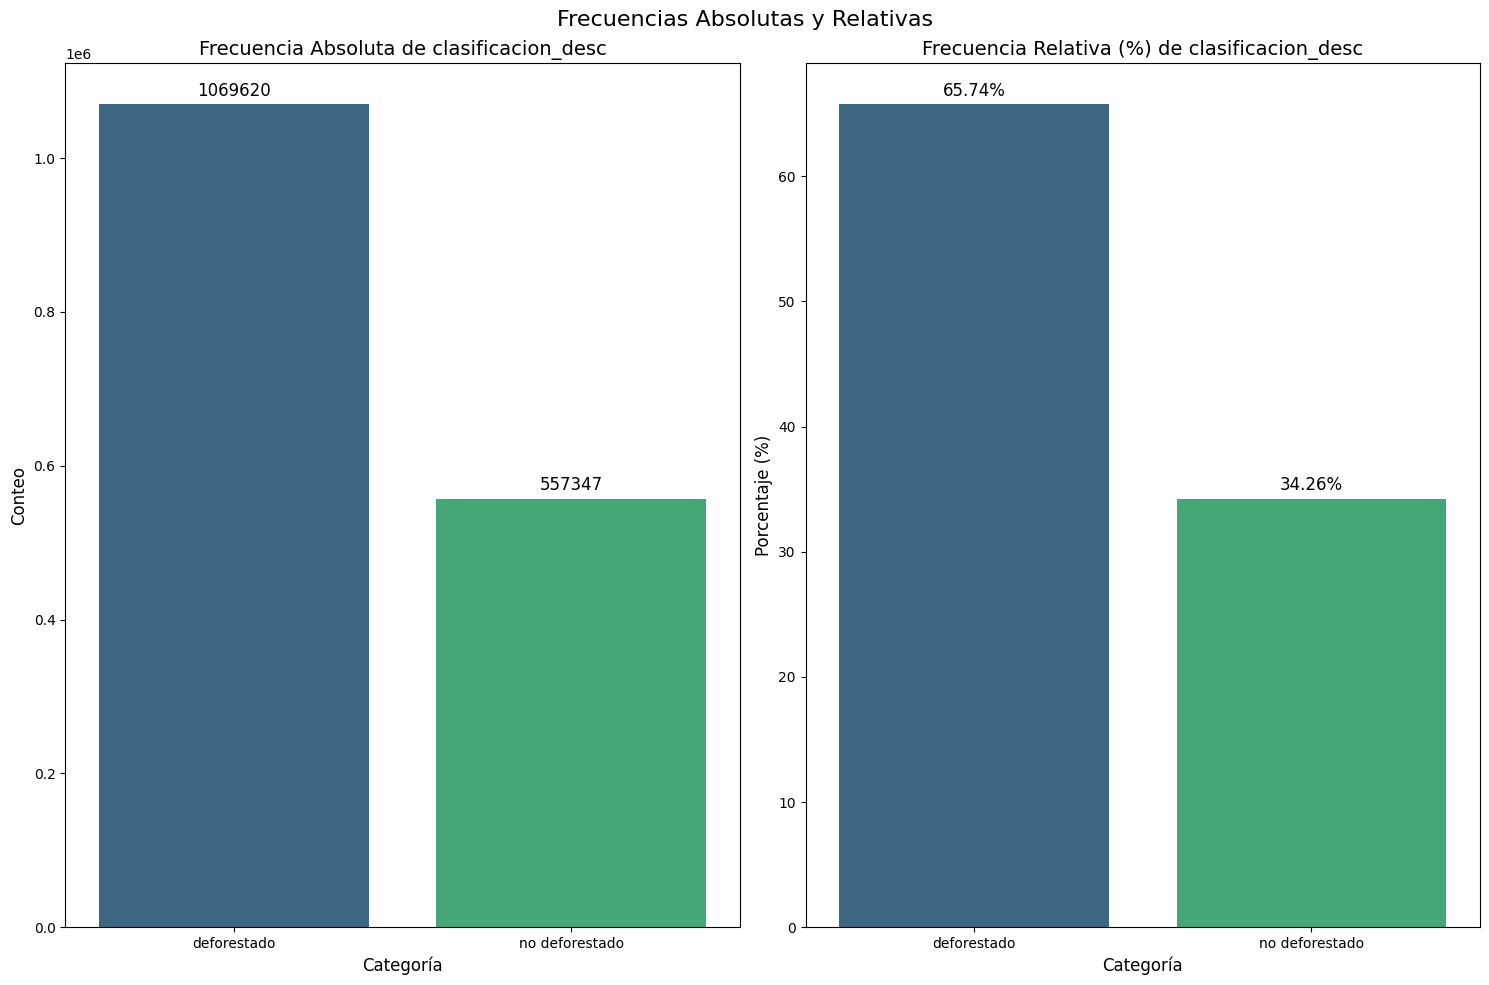

In [63]:
plot_frecuencias(df,var_cat)

#### ANÁLISIS UNIVARIANTE - Numéricas

In [46]:
# ANÁLISIS UNIVARIANTE
pd.options.display.float_format = '{:.2f}'.format # para evitar que muestre los resultados con notación exponencial
df[var_num].describe()

,mag_norm,yod,dur,rate_norm,preval_norm,dsnr
count,1626967.00,1626967.00,1626967.00,1626967.00,1626967.00,1626967.00
mean,0.14,2011.36,2.87,0.12,0.26,8.15
std,0.09,5.91,4.54,0.10,0.02,5.42
min,0.00,2001.00,1.00,0.00,0.00,0.00
25%,0.07,2006.00,1.00,0.04,0.25,4.54
50%,0.13,2011.00,1.00,0.10,0.26,6.94
75%,0.20,2017.00,2.00,0.19,0.27,10.47
max,1.00,2021.00,23.00,1.00,1.00,79.61


In [47]:
# Análisis moda
df[["yod","dur"]].mode().T

# Para las variables yod y duración, que son numéricas discretas, la moda es un estadístico de tendencia central que ayuda a entender y caracterizar los loss bid-delta
# En 2009 se registró el máximo de píxeles con pérdidas de señal espectral (potenciales eventos de deforestación)
# La mayoría de los big-deltas tienen una duración de 1 año, por lo son cambios abruptos.

,0
yod,2009
dur,1


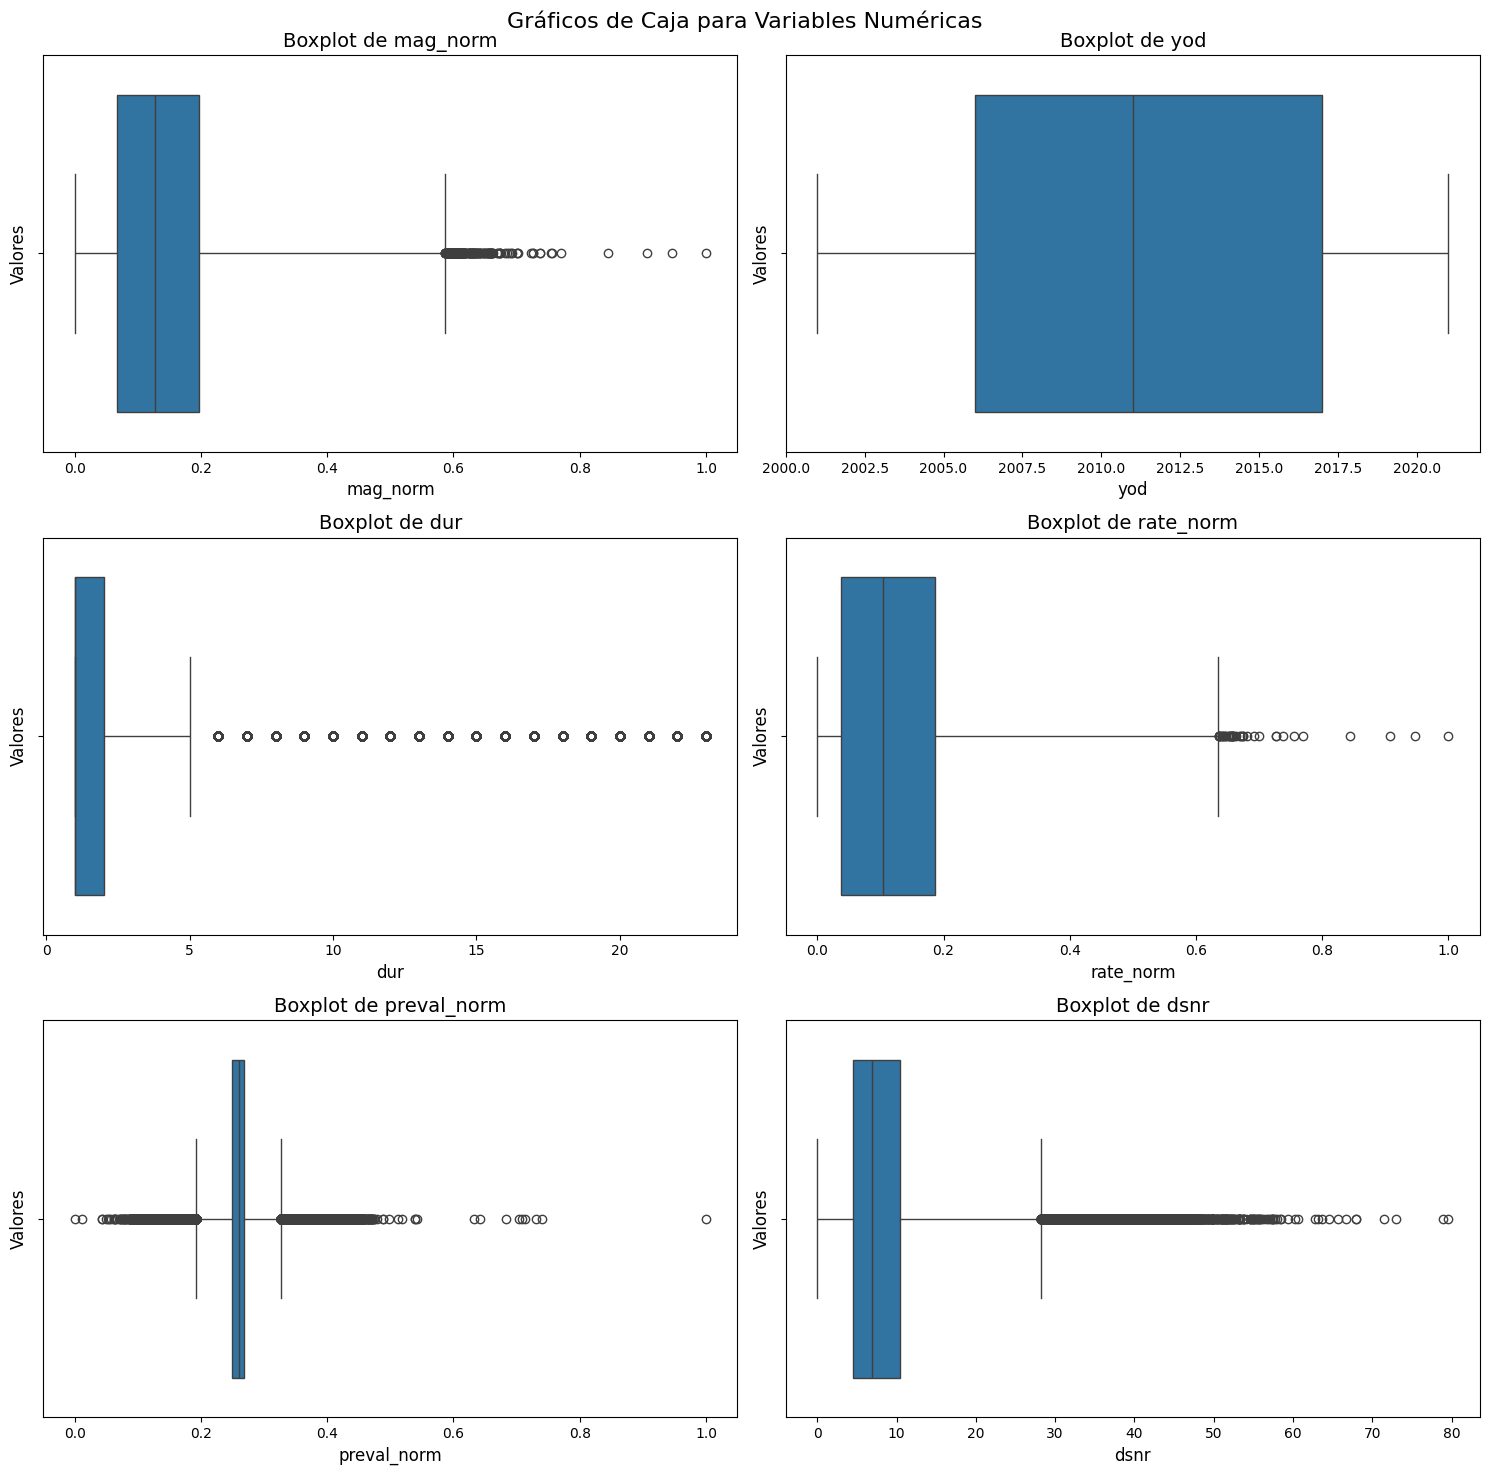

In [48]:
# ANÁLISIS OUTLIERS CON BOXPLOT
plot_boxplots(df,var_num)

In [49]:
# ANÁLISIS DE VARIABILIDAD Y DISPERSIÓN
variabilidad(df[var_num])

,std,mean,CV
mag_norm,0.09,0.14,63.94
yod,5.91,2011.36,0.29
dur,4.54,2.87,158.08
rate_norm,0.10,0.12,79.28
preval_norm,0.02,0.26,8.32
dsnr,5.42,8.15,66.46


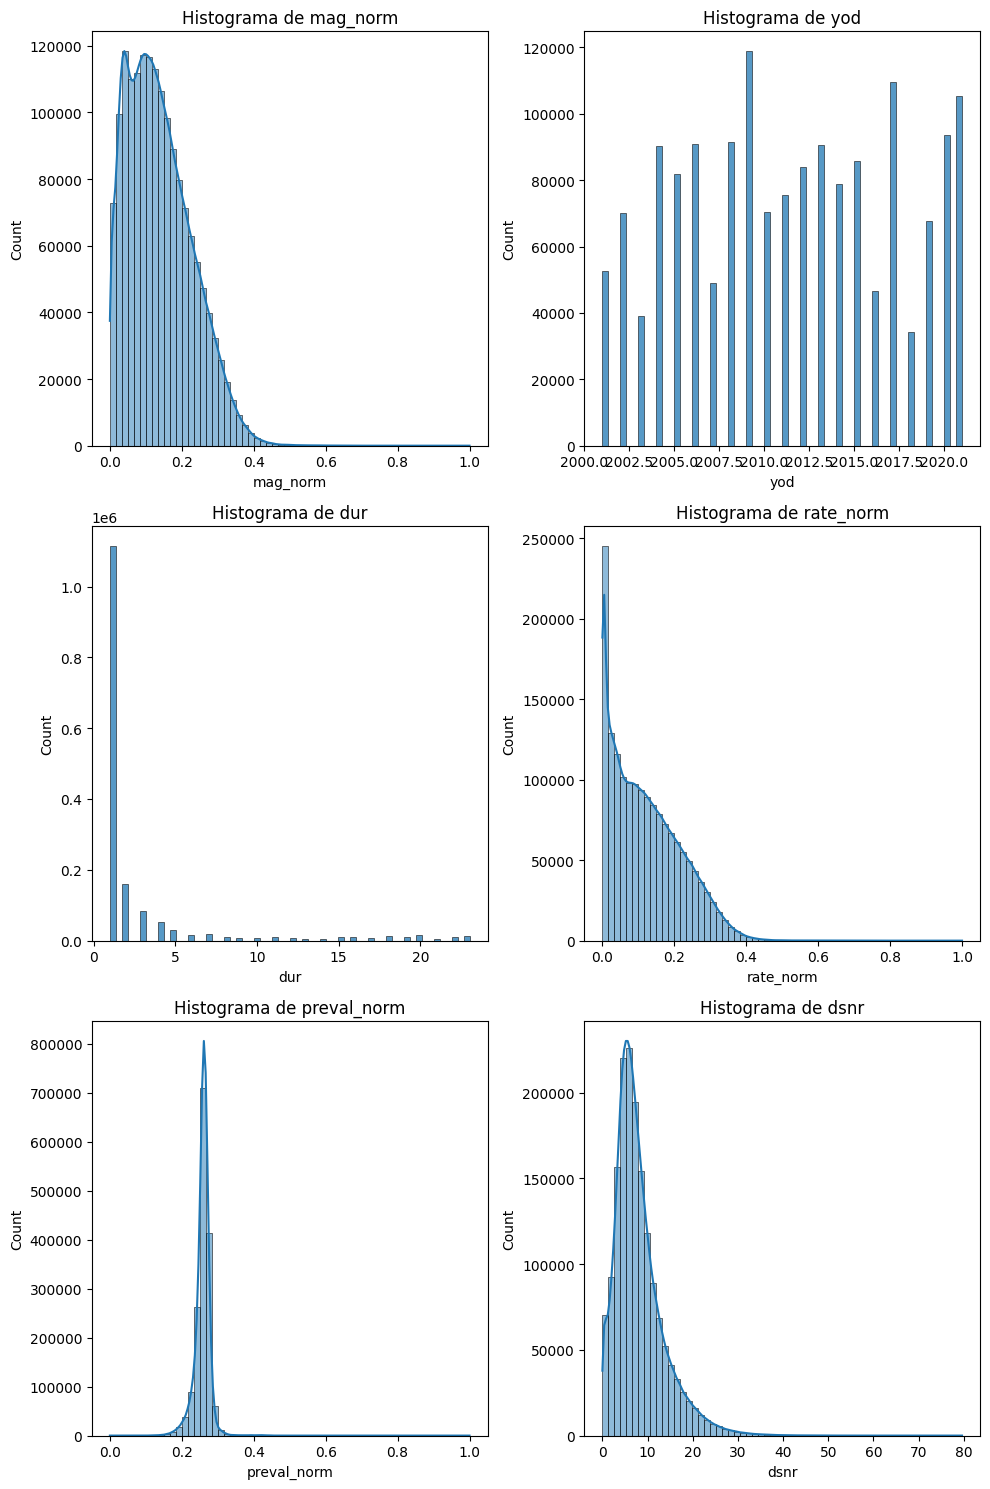

In [50]:
plot_hist(df,var_num,[60,60,60,60,60,60],[True,False,False,True,True,True])

#### ANÁLISIS BIVARIANTE

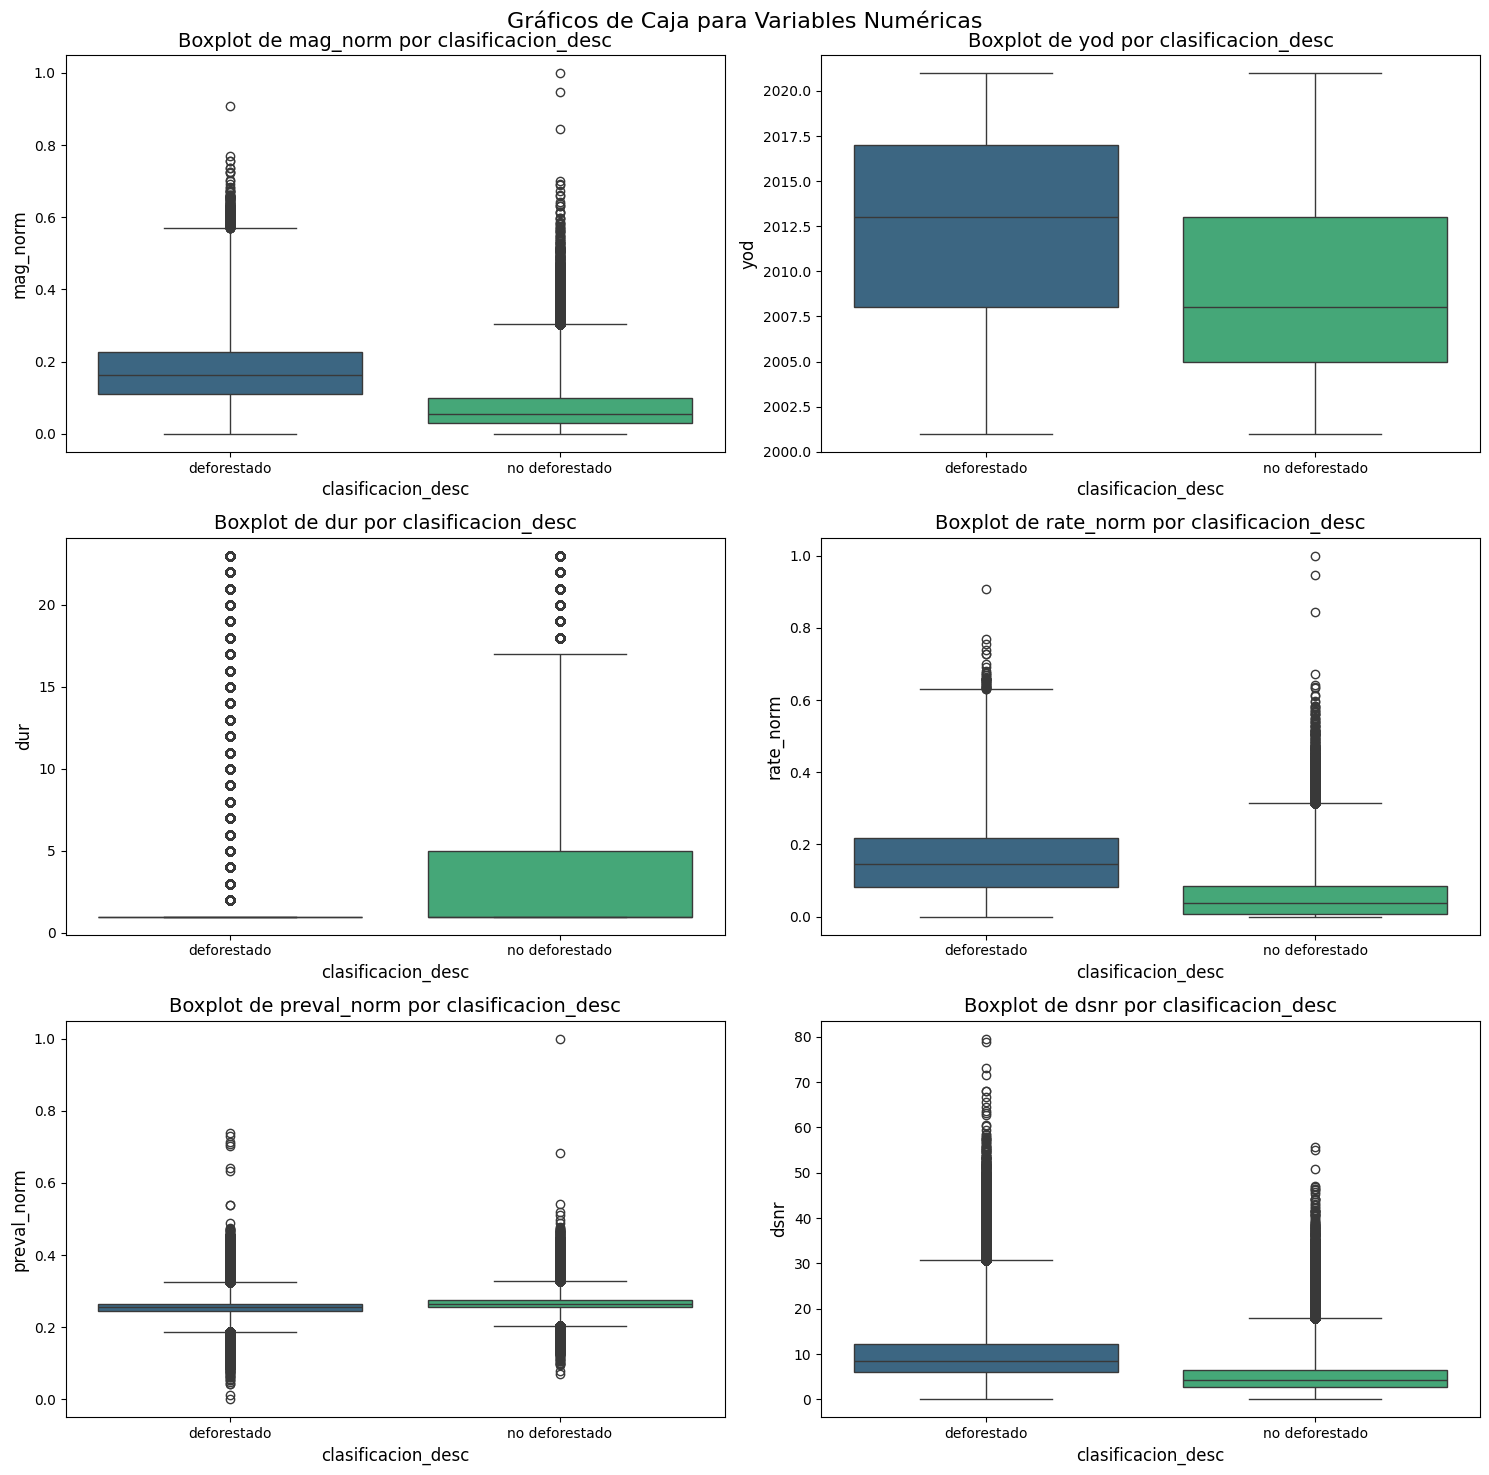

In [51]:
plot_boxplots(df,var_num,"clasificacion_desc")

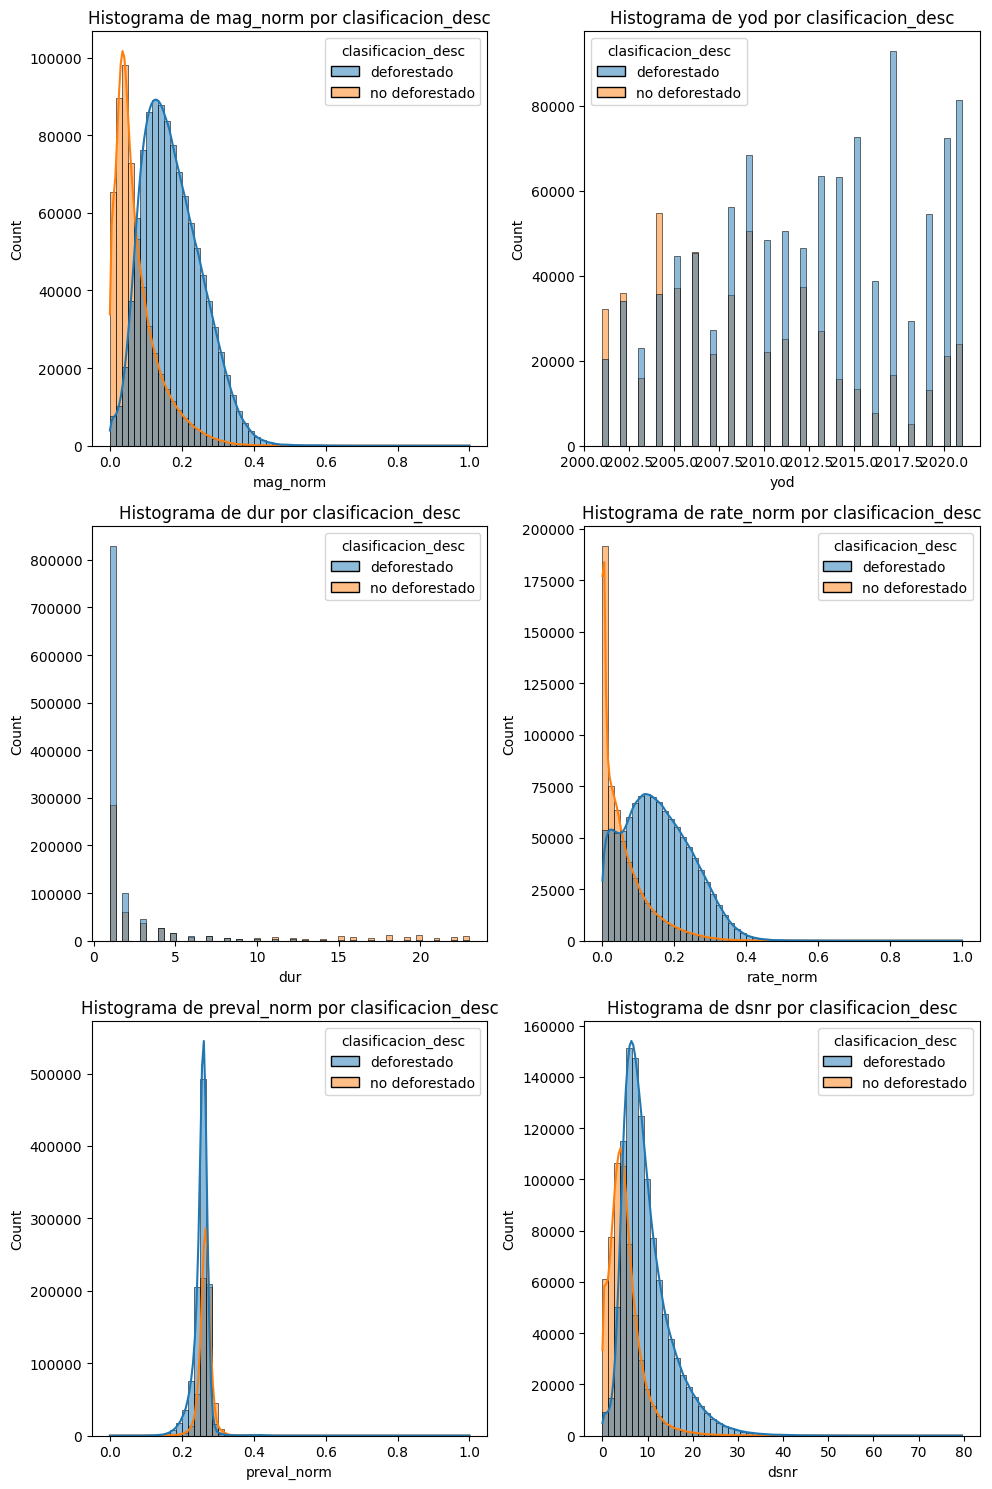

In [52]:
plot_hist(df,var_num,[60,60,60,60,60,60],[True,False,False,True,True,True],"clasificacion_desc")

#### Aplicando la prueba U de Mann-Whitney:

Comparar las distribuciones de las variables cuando estas están agrupadas por los valores de la variable de clasificación

In [53]:
test = app_mannwhitney(df,var_num,"clasificacion_desc","deforestado","no deforestado")

# Mostrar los resultados
for var, res in test.items():
    print(f"Variable: {var}")
    print(f"  Estadístico U: {res['U_stat']}")
    print(f"  Valor p: {res['p_valor']}")
    print(f"  Tamaño del efecto (r): {res['r']}\n")

Variable: mag_norm
  Estadístico U: 506924313832.0
  Valor p: 0.0
  Tamaño del efecto (r): 0.5759273838370722

Variable: yod
  Estadístico U: 396174176113.0
  Valor p: 0.0
  Tamaño del efecto (r): 0.27052077622079157

Variable: dur
  Estadístico U: 208259060866.5
  Valor p: 0.0
  Tamaño del efecto (r): -0.2476773863211789

Variable: rate_norm
  Estadístico U: 485576641606.5
  Valor p: 0.0
  Tamaño del efecto (r): 0.5170586520307392

Variable: preval_norm
  Estadístico U: 187785059348.0
  Valor p: 0.0
  Tamaño del efecto (r): -0.30413686778892

Variable: dsnr
  Estadístico U: 477933143143.0
  Valor p: 0.0
  Tamaño del efecto (r): 0.4959808007148279



Valor p: En todos los casos, el valor p es 0.0, lo que indica que es menor que cualquier nivel de significancia comúnmente utilizado (por ejemplo, 0.05 o 0.01). Esto sugiere que hay diferencias estadísticamente significativas entre los grupos "deforestado" y "no deforestado" para cada una de las variables numéricas analizadas. 

Interpretación de r:
* 0.1 ≤ |r| < 0.3: Tamaño del efecto pequeño.
* 0.3 ≤ |r| < 0.5: Tamaño del efecto mediano.
* |r| ≥ 0.5: Tamaño del efecto grande.

Tamaño del efecto: Mide la magnitud de la diferencia entre grupos, proporcionando información sobre la relevancia práctica de los resultados. Un tamaño del efecto grande indica una diferencia sustancial que puede tener implicaciones significativas en el contexto del estudio.


#### ANALISIS MULTIVARIANTE

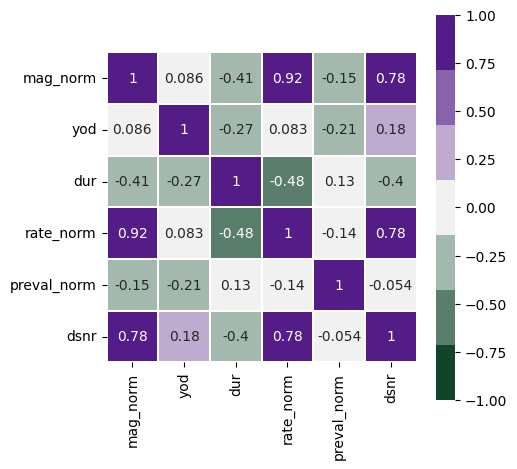

In [54]:
matriz_corr = df[var_num].corr(numeric_only= True)
plt.figure(figsize=(5,5))
sns.heatmap(matriz_corr,
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.1,
            annot=True);

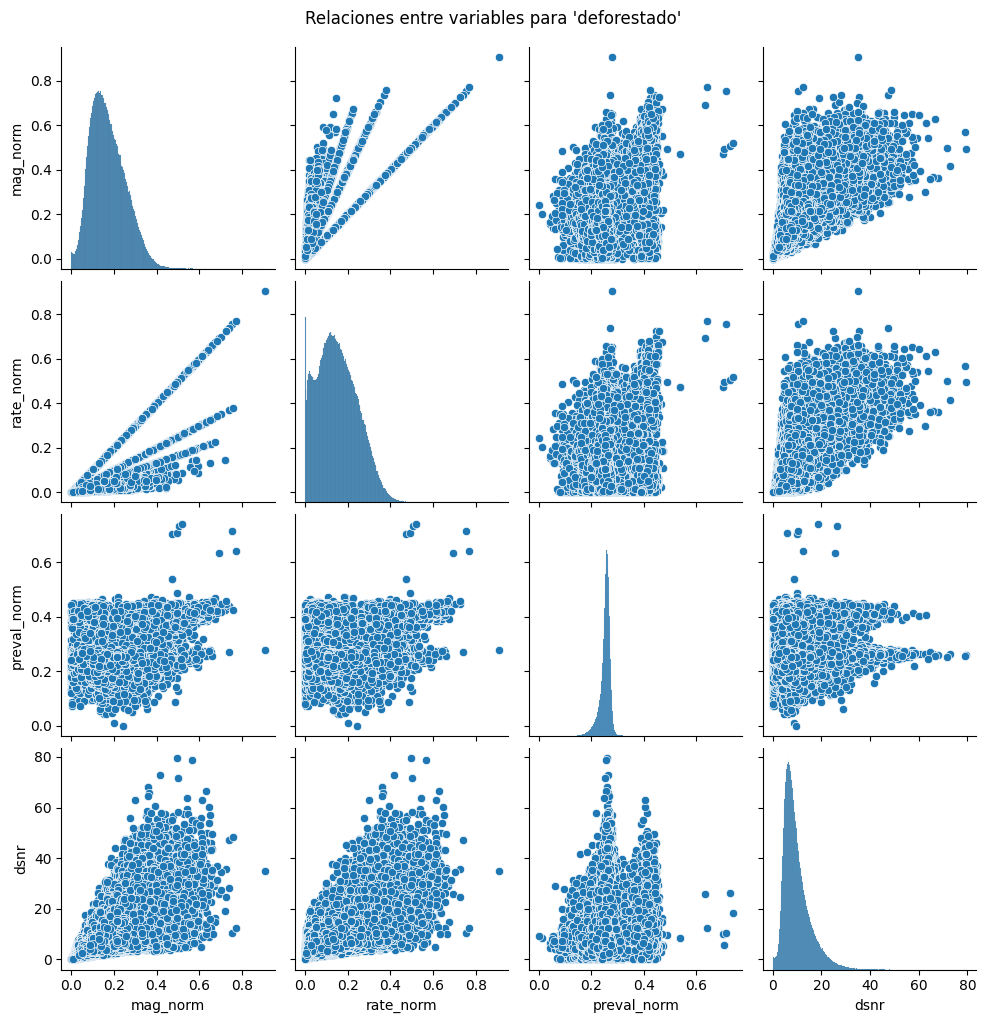

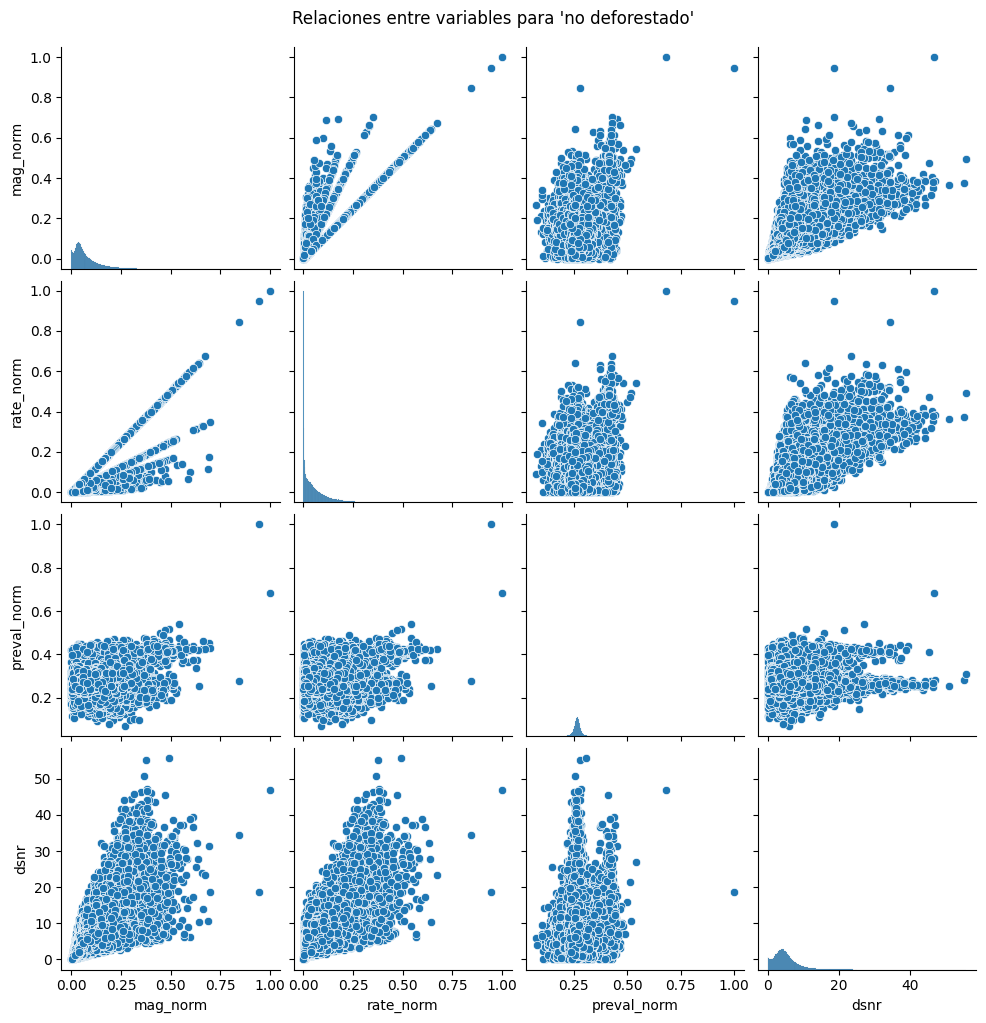

In [55]:
# Filtrar el DataFrame para cada categoría
df_deforestado = df[df["clasificacion_desc"] == "deforestado"]
df_no_deforestado = df[df["clasificacion_desc"] == "no deforestado"]

sns.pairplot(df_deforestado[["mag_norm","rate_norm","preval_norm","dsnr"]])
plt.suptitle("Relaciones entre variables para 'deforestado'", y=1.02)
plt.show()

sns.pairplot(df_no_deforestado[["mag_norm","rate_norm","preval_norm","dsnr"]])
plt.suptitle("Relaciones entre variables para 'no deforestado'", y=1.02)
plt.show()

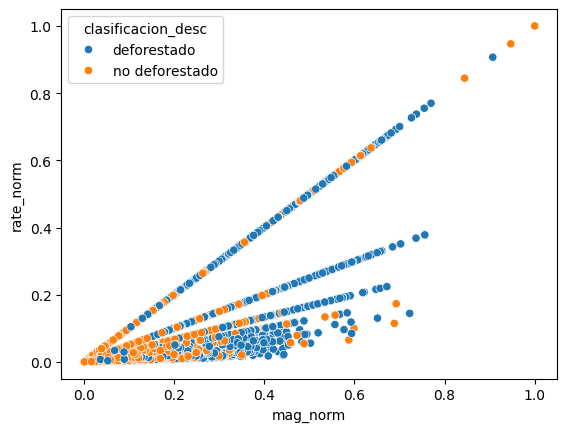

In [56]:
sns.scatterplot(x="mag_norm", y= "rate_norm", data = df, hue = "clasificacion_desc");

In [57]:
df_deforestado[var_num].describe()

,mag_norm,yod,dur,rate_norm,preval_norm,dsnr
count,1069620.00,1069620.00,1069620.00,1069620.00,1069620.00,1069620.00
mean,0.17,2012.51,1.84,0.15,0.25,9.78
std,0.08,5.71,2.62,0.09,0.02,5.48
min,0.00,2001.00,1.00,0.00,0.00,0.00
25%,0.11,2008.00,1.00,0.08,0.25,6.01
50%,0.16,2013.00,1.00,0.15,0.26,8.44
75%,0.23,2017.00,1.00,0.22,0.27,12.20
max,0.91,2021.00,23.00,0.91,0.74,79.61


In [58]:
# Análisis moda de áreas deforestadas
df_deforestado[["yod","dur"]].mode().T

,0
yod,2017
dur,1


In [59]:
df_no_deforestado[var_num].describe()

,mag_norm,yod,dur,rate_norm,preval_norm,dsnr
count,557347.00,557347.00,557347.00,557347.00,557347.00,557347.00
mean,0.07,2009.16,4.85,0.06,0.27,5.02
std,0.06,5.65,6.40,0.07,0.02,3.64
min,0.00,2001.00,1.00,0.00,0.07,0.00
25%,0.03,2005.00,1.00,0.01,0.26,2.66
50%,0.06,2008.00,1.00,0.04,0.27,4.38
75%,0.10,2013.00,5.00,0.08,0.27,6.48
max,1.00,2021.00,23.00,1.00,1.00,55.73


#### VISUALIZACIONES Y DATOS RELEVANTES

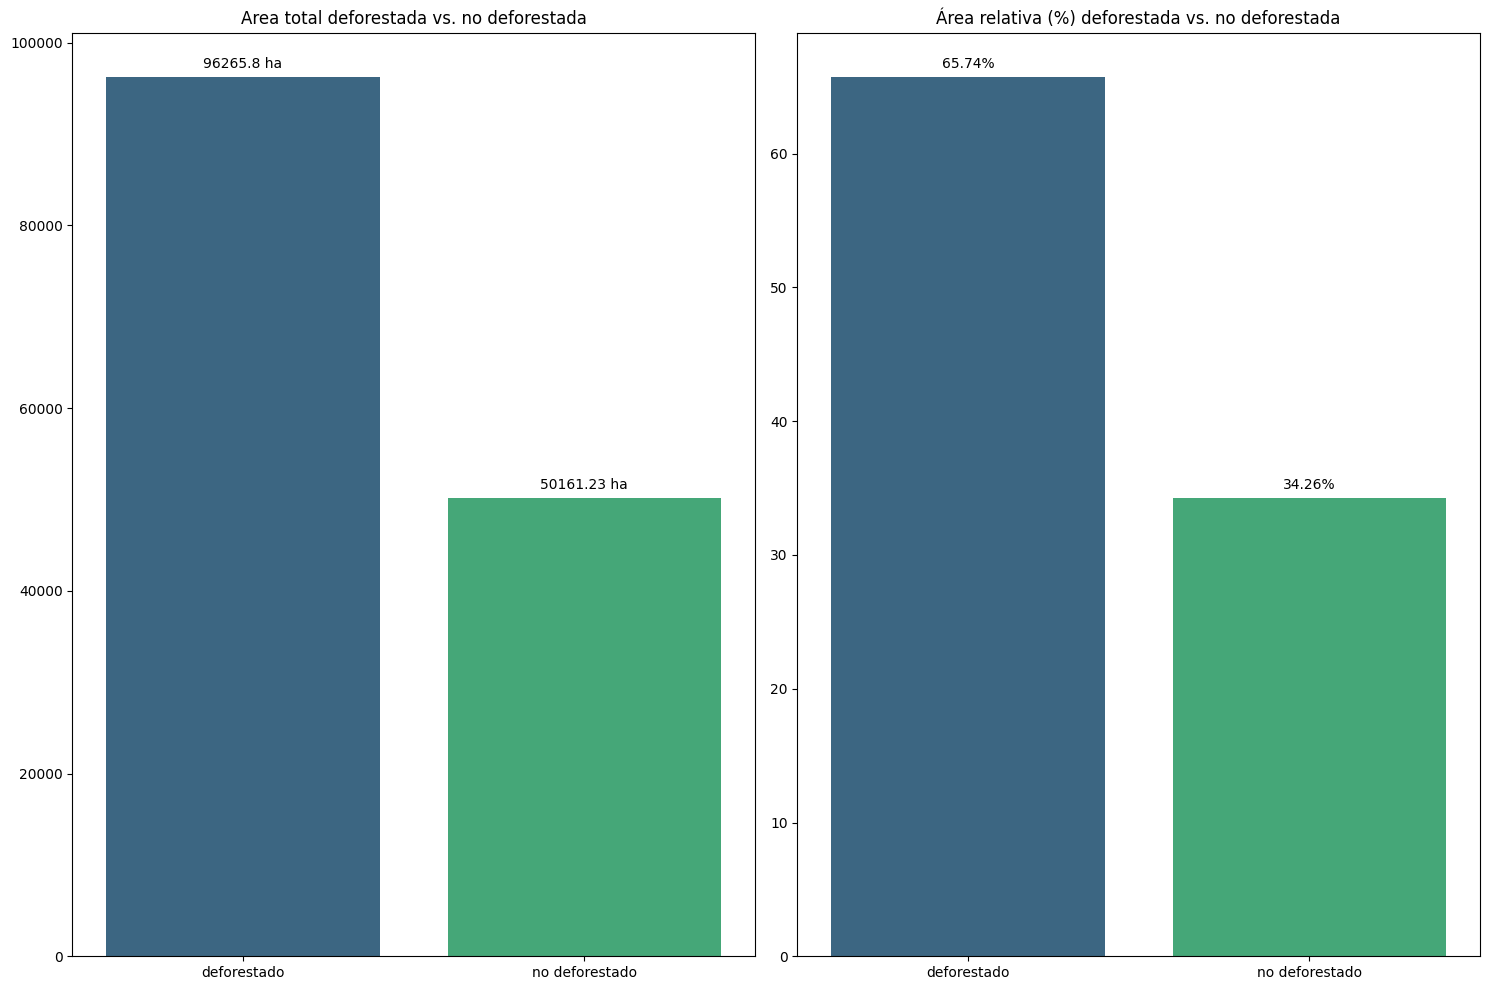

In [60]:
# DATOS SOBRE DEFORESTACIÓN

# Calcular frecuencias absolutas y relativas
area_total = df["clasificacion_desc"].value_counts()*900*0.0001 # para calcular el área se multiplica por 900 m2 (superficie de los píxeles en base a su resolución espacial de 30 m) y se transforma a ha (x 0.0001)
area_relativa = df["clasificacion_desc"].value_counts(normalize=True) * 100


# Figura de áreas deforestadas vs. áreas no deforestada
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
# fig.suptitle("Frecuencias Absolutas y Relativas", fontsize=16)

# Determinar el desplazamiento proporcional para las etiquetas
desp_absoluto = max(area_total) * 0.01  # 1% del valor máximo
desp_relativo = max(area_relativa) * 0.01  # 1% del valor máximo

# Gráfico de áreas totales
sns.barplot(
    x=area_total.index,
    y=area_total.values,
    hue=area_total.index,
    # data=df,
    palette="viridis",
    ax=axs[0]
)
axs[0].set_title(f'Area total deforestada vs. no deforestada', fontsize=12)
axs[0].set_xlabel('', fontsize=12)
# axs[0].set_ylabel('Área (ha)', fontsize=12)
for j, value in enumerate(area_total.values):
    axs[0].text(j, value + desp_absoluto, f'{value} ha', ha='center', fontsize=10)

# Gráfico de Frecuencias Relativas
sns.barplot(
    x=area_relativa.index,
    y=area_relativa.values,
    hue=area_relativa.index,
    # data=df,
    palette='viridis',
    ax=axs[1],
)
axs[1].set_title(f'Área relativa (%) deforestada vs. no deforestada', fontsize=12)
axs[1].set_xlabel('', fontsize=12)
# axs[1].set_ylabel('Porcentaje (%)', fontsize=12)
for j, value in enumerate(area_relativa.values):
    axs[1].text(j, value + desp_relativo, f'{value:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

* En el área de estudio, provincia Padre Abad en Ucayali, Perú, se ha estimado una deforestación de 96.265,8 hectáreas en el periodo comprendido entre los años 2001 y 2021. Esta superficie equivale aproximadamente a 134,800 campos de fútbol, o la mitad de la superficie de la isla de Tenerife. La superficie deforestada equivale a más del 65% del área estudiada. 

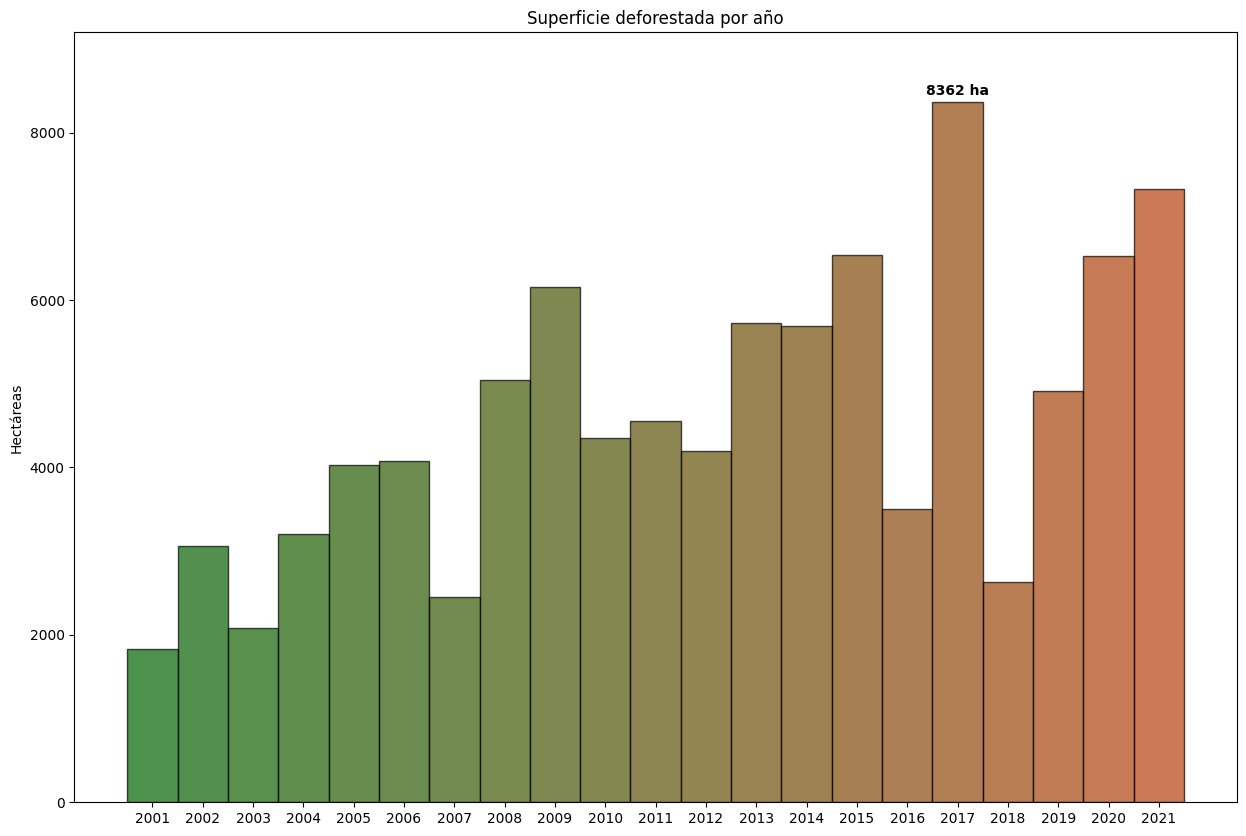

In [61]:
# PATRÓN TEMPORAL DE LA DEFORESTACIÓN

# Figura del año de deforestación
plt.figure(figsize=(15, 10))

# Valores únicos de la variable 'yod' ordenados
years = sorted(df_deforestado['yod'].unique())
bins = np.arange(min(years), max(years) + 2)  # Definir bins manualmente para el histograma

# Crear un color degradado personalizado de verde a marrón y crear la paleta
colors = LinearSegmentedColormap.from_list(
    "verde_oscuro_marron_naranja",
    ["#006400", "#B7410E"],  # Verde muy oscuro → Marrón anaranjado
    N=len(bins) - 1)
palette = [colors(i / (len(bins) - 2)) for i in range(len(bins) - 1)]  # Lista de colores

# Histograma base 
sns.histplot(
    data=df_deforestado, #subset del df con los registros sólo para píxeles donde se ha identificado deforestación
    x="yod",
    bins=bins)

# Ajustar color y la altura de las barras a hectáreas
ax = plt.gca() # crear objeto ax con cada una de las barras del histograma
bar_width = 0.6  # Ancho de las barras
max_height = 0   # Variable para registrar el máximo

for patch, color in zip(ax.patches, palette): # Extraer cada barra del objeto ax
    # Ajustar el color y la altura
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_height(patch.get_height() * 0.09)  # Ajustar altura a hectáreas
    
    # Identificar la barra con el mayor conteo
    if patch.get_height() > max_height:
        max_height = patch.get_height()
        max_patch = patch  # Almacena la barra más alta

# Agregar texto con la superficie deforestada sobre la barra más alta
ax.text(
    max_patch.get_x() + max_patch.get_width() / 2,  # Posición x centrada
    max_patch.get_height() + 50,  # Posición y justo encima de la barra
    f"{int(max_patch.get_height())} ha",  # Texto con el valor en hectáreas
    ha='center', va='bottom', fontsize=10, color='black', fontweight='bold'
)

# Recalibrar el eje y
ax.set_ylim(0, max_height * 1.1)  # Ligeramente más alto para claridad

# Ajustar los xticks al centro de cada bin
centers = bins[:-1] + 0.5  # Centros de los bins
plt.xticks(centers, years)  # Posicionar los ticks en los centros

# Títulos y etiquetas
plt.title("Superficie deforestada por año")
plt.xlabel('')
plt.ylabel('Hectáreas')

# Mostrar
plt.show()


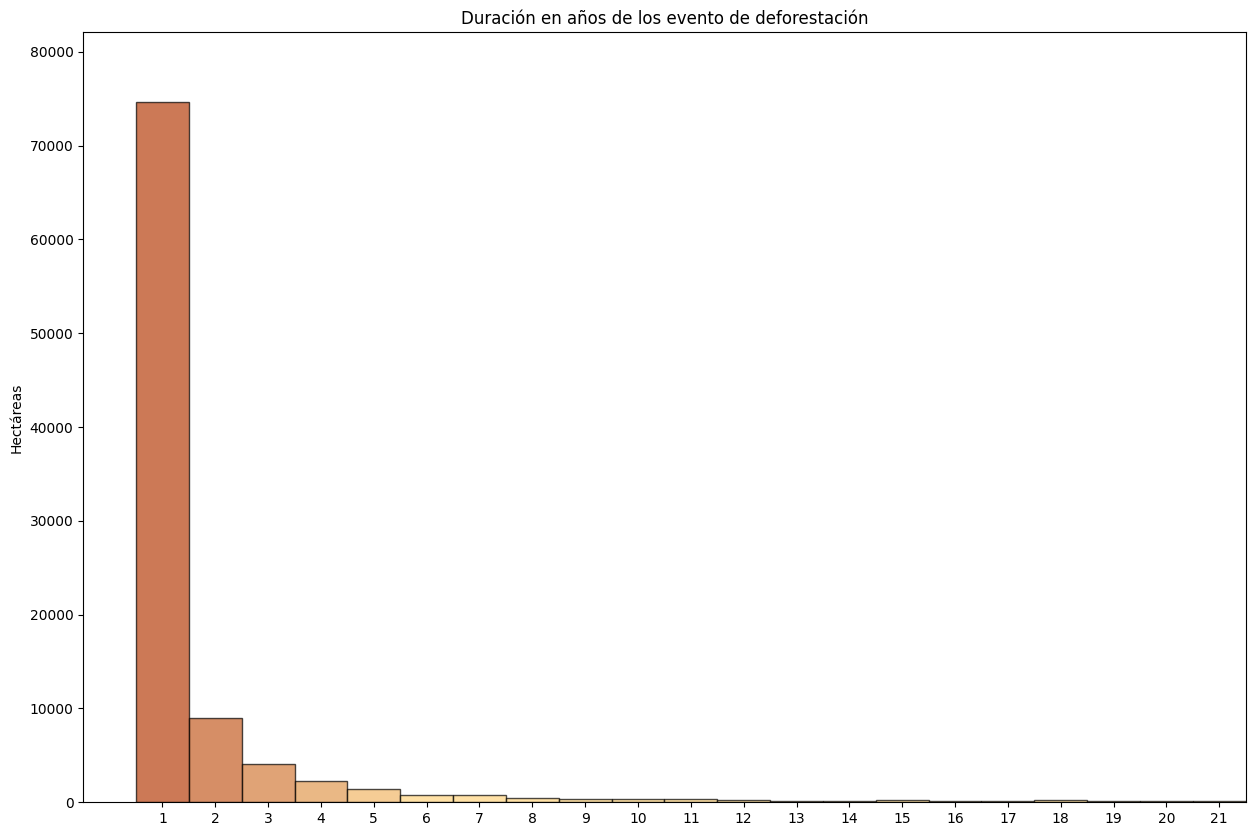

In [62]:
# Figura de duración de los eventos de deforestación
plt.figure(figsize=(15, 10))

# Valores únicos de la variable 'yod' ordenados
years = sorted(df_deforestado['dur'].unique())
bins = np.arange(min(years), max(years)+2)  # Definir bins manualmente para el histograma

# Crear un degradado de marrón oscuro a naranja claro
colors = LinearSegmentedColormap.from_list(
    "marron_naranja_claro",
    ["#B7410E", "#FFD580"],  # Marrón oscuro → Naranja claro
    N=6  # 7 pasos para las primeras 7 barras
)
# Crear la lista de colores para 24 bins
palette = [colors(i / 6) if i < 7 else colors(6 / 6) for i in range(24)]

# Histograma base
sns.histplot(
    data=df_deforestado, #subset del df con los registros sólo para píxeles donde se ha identificado deforestación
    x="dur",
    bins=bins)

# Ajustar color y la altura de las barras a hectáreas
ax = plt.gca()
bar_width = 0.5  # Ancho de las barras
for patch, color in zip(ax.patches, palette):
    patch.set_facecolor(color)       # Aplicar degradado de color
    patch.set_alpha(0.7)             # Añadir transparencia
    patch.set_height(patch.get_height() * 0.09)  # Ajustar altura para superficie

# Recalibrar el eje y
max_height = max(patch.get_height() for patch in ax.patches)  # Altura máxima ajustada
ax.set_ylim(0, max_height * 1.1)  # Ligeramente más alto para claridad

# Ajustar los xticks al centro de cada bin
centers = bins[:-1] + 0.5  # Centros de los bins
plt.xticks(centers, years)  # Posicionar los ticks en los centros

# Títulos y etiquetas
plt.title("Duración en años de los evento de deforestación")
plt.xlim(0,22)
plt.xlabel('')
plt.ylabel('Hectáreas')

# Mostrar
plt.show()

* El año 2017 fue cuando se registrón el máximo de área deforestada anual
* Los eventos de deforestación tiene mayoritariamente una duración de 1 año, por lo que son cambios muy bruscos en la cobertura del suelo. Este patrón está generalmente asociado a procesos de deforestación por incendios forestales o clareo para impalntación de explotaciones agrícolas

In [63]:
variabilidad(df[["mag_norm","rate_norm","preval_norm","dsnr"]])

,std,mean,CV
mag_norm,0.09,0.14,63.94
rate_norm,0.10,0.12,79.28
preval_norm,0.02,0.26,8.32
dsnr,5.42,8.15,66.46


In [64]:
variabilidad(df_no_deforestado[["mag_norm","rate_norm","preval_norm","dsnr"]])

,std,mean,CV
mag_norm,0.06,0.07,84.32
rate_norm,0.07,0.06,112.86
preval_norm,0.02,0.27,6.83
dsnr,3.64,5.02,72.39


In [65]:
variabilidad(df_deforestado[["mag_norm","rate_norm","preval_norm","dsnr"]])

,std,mean,CV
mag_norm,0.08,0.17,47.09
rate_norm,0.09,0.15,60.26
preval_norm,0.02,0.25,8.62
dsnr,5.48,9.78,55.99


* Las variables o características muestrasn un alta variabilidad, aunque se reduce cuando se consideran únicamente los registros de las áreas clasificadas como deforestadas

C:\Users\maria\AppData\Local\Temp\ipykernel_22556\2676494310.py:7: UserWarning: The palette list has more values (24) than needed (2), which may not be intended.
  sns.histplot(data=df, x="mag_norm", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[0, 0], legend=False)
C:\Users\maria\AppData\Local\Temp\ipykernel_22556\2676494310.py:13: UserWarning: The palette list has more values (24) than needed (2), which may not be intended.
  sns.histplot(data=df, x="rate_norm", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[0, 1], legend=False)
C:\Users\maria\AppData\Local\Temp\ipykernel_22556\2676494310.py:19: UserWarning: The palette list has more values (24) than needed (2), which may not be intended.
  sns.histplot(data=df, x="preval_norm", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[1, 0], legend=False)
C:\Users\maria\AppData\Local\Temp\ipykernel_22556\2676494310.py:25: UserWarning: The palette list has more values (24) than 

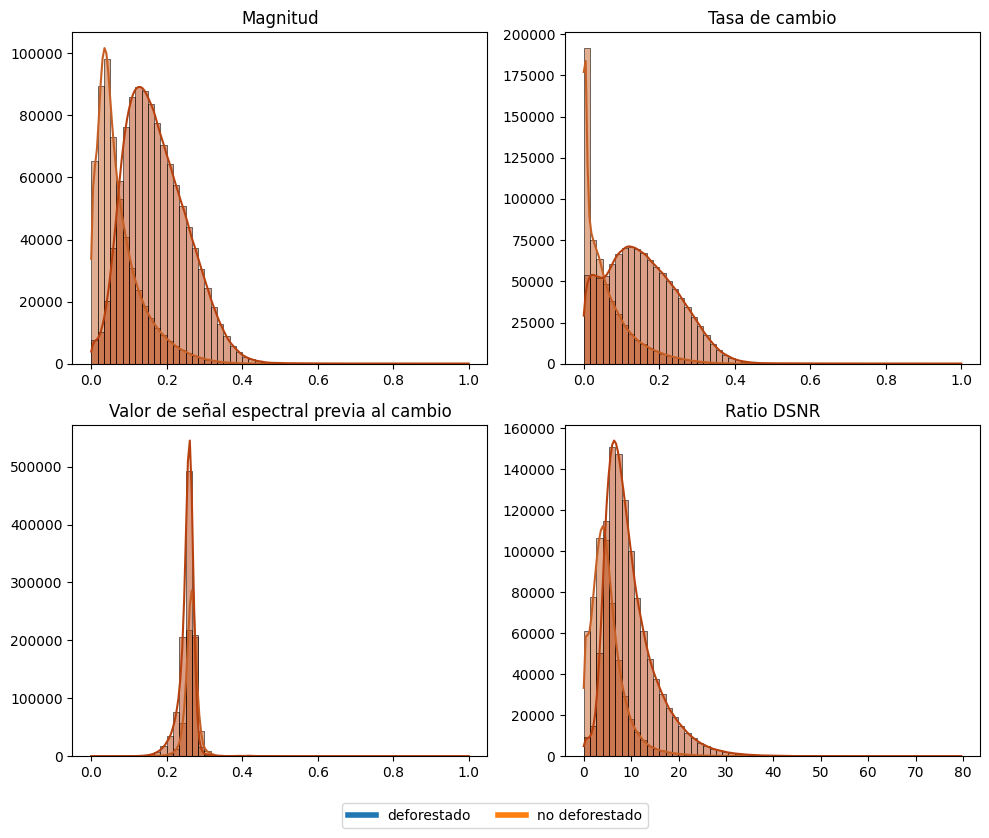

In [66]:
# VISUALISAR LAS DISTRIBUCIONES DE LAS VARIABLES PARA CADA SUBSET (DEFORESTADO VS. NO DEFORESTADO)

# Crear subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Primer subplot (sin leyenda local)
sns.histplot(data=df, x="mag_norm", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[0, 0], legend=False)
axs[0, 0].set_title("Magnitud")
axs[0, 0].set_xlabel("")
axs[0, 0].set_ylabel("")

# Segundo subplot
sns.histplot(data=df, x="rate_norm", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[0, 1], legend=False)
axs[0, 1].set_title("Tasa de cambio")
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")

# Tercer subplot
sns.histplot(data=df, x="preval_norm", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[1, 0], legend=False)
axs[1, 0].set_title("Valor de señal espectral previa al cambio")
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")

# Cuarto subplot
sns.histplot(data=df, x="dsnr", hue="clasificacion_desc", kde=True, bins=60, palette=palette, ax=axs[1, 1], legend=False)
axs[1, 1].set_title("Ratio DSNR")
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")

# Ajuste del layout
plt.tight_layout()

# crear leyenda global
unique_hue = df['clasificacion_desc'].unique()  # Obtener los valores únicos de la variable 'hue' / variable categórica de clasificación
palette = sns.color_palette("tab10", len(unique_hue))  # Definir la paleta de colores

# Crear handles y labels manualmente
handles = [plt.Line2D([0], [0], color=palette[i], lw=4) for i in range(len(unique_hue))]
labels = [str(label) for label in unique_hue]

# pintar la leyenda
fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=len(unique_hue),
    fontsize=10
)

# Mostrar la figura
plt.show()


In [67]:
df_deforestado[["mag_norm","rate_norm","preval_norm","dsnr"]].describe()

,mag_norm,rate_norm,preval_norm,dsnr
count,1069620.00,1069620.00,1069620.00,1069620.00
mean,0.17,0.15,0.25,9.78
std,0.08,0.09,0.02,5.48
min,0.00,0.00,0.00,0.00
25%,0.11,0.08,0.25,6.01
50%,0.16,0.15,0.26,8.44
75%,0.23,0.22,0.27,12.20
max,0.91,0.91,0.74,79.61


In [68]:
df_no_deforestado[["mag_norm","rate_norm","preval_norm","dsnr"]].describe()

,mag_norm,rate_norm,preval_norm,dsnr
count,557347.00,557347.00,557347.00,557347.00
mean,0.07,0.06,0.27,5.02
std,0.06,0.07,0.02,3.64
min,0.00,0.00,0.07,0.00
25%,0.03,0.01,0.26,2.66
50%,0.06,0.04,0.27,4.38
75%,0.10,0.08,0.27,6.48
max,1.00,1.00,1.00,55.73


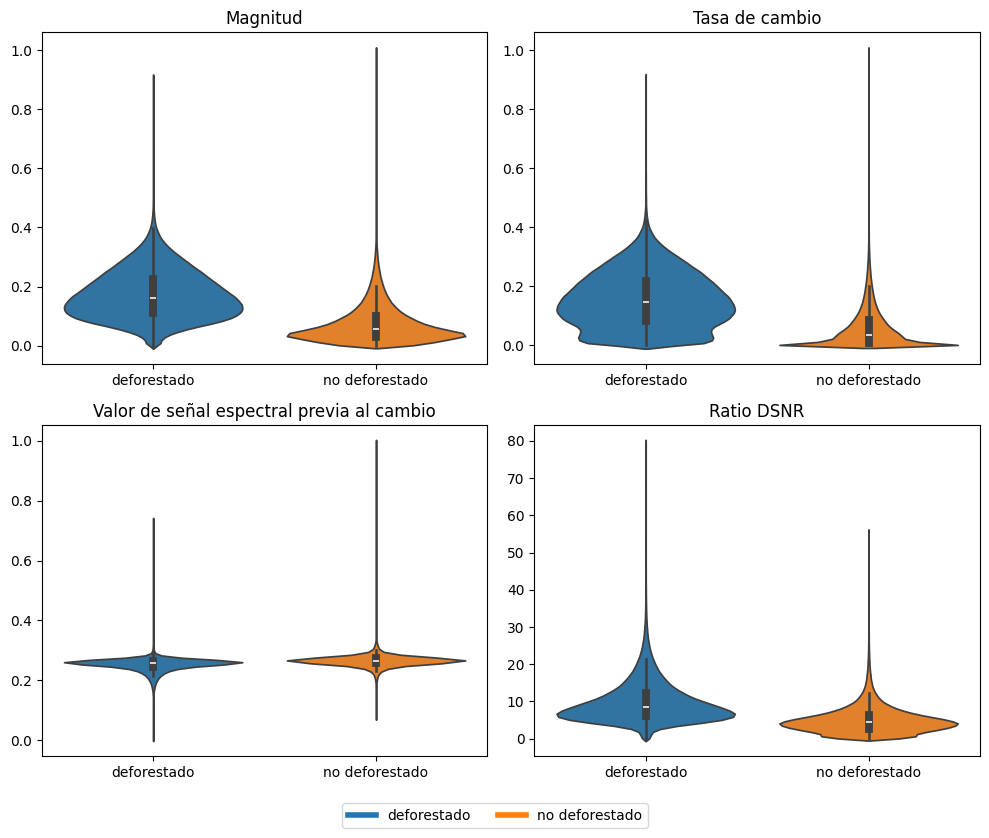

In [69]:
# VISUALIZACIÓN CON PLOTS DE VIOLÍN

# Paleta de colores para las clases
unique_hue = df['clasificacion_desc'].unique()  # Obtener los valores únicos de la variable 'hue'
palette = sns.color_palette("tab10", len(unique_hue))  # Paleta de colores personalizada

# Crear subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Primer subplot: "Magnitud"
sns.violinplot(
    data=df, x="clasificacion_desc", y="mag_norm", hue="clasificacion_desc",
    palette=palette, ax=axs[0, 0], legend=False
)
axs[0, 0].set_title("Magnitud")
axs[0, 0].set_xlabel("")
axs[0, 0].set_ylabel("")

# Segundo subplot: "Tasa de cambio"
sns.violinplot(
    data=df, x="clasificacion_desc", y="rate_norm", hue="clasificacion_desc",
    palette=palette, ax=axs[0, 1], legend=False
)
axs[0, 1].set_title("Tasa de cambio")
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")

# Tercer subplot: "Valor de señal espectral previa al cambio"
sns.violinplot(
    data=df, x="clasificacion_desc", y="preval_norm", hue="clasificacion_desc",
    palette=palette, ax=axs[1, 0], legend=False
)
axs[1, 0].set_title("Valor de señal espectral previa al cambio")
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")

# Cuarto subplot: "Ratio DSNR"
sns.violinplot(
    data=df, x="clasificacion_desc", y="dsnr", hue="clasificacion_desc",
    palette=palette, ax=axs[1, 1], legend=False
)
axs[1, 1].set_title("Ratio DSNR")
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Crear handles y etiquetas manualmente para la leyenda global
handles = [plt.Line2D([0], [0], color=palette[i], lw=4) for i in range(len(unique_hue))]
labels = [str(label) for label in unique_hue]

# Crear leyenda global
fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=len(unique_hue),
    fontsize=10
)

# Mostrar la figura
plt.show()


* Se identifica un patrón diferencia entre las áreas deforestadas y no deforestadas, principalmente para las variables magnitud y tasa de cambio (rate)
* Los resultados de la prueba U de Mann-Whitney validan que hay una diferencia muy clara y estadísticamente significativa entre las áreas deforestadas y no deforestadas para las variables numéricas cuantitativas analizadas. Igualmente el tamaño de efecto (r) indica que hay una diferencia sustancial para las variables magnitud y tasa
* Las funciones de distribución de la variable preval se solapan prácticamente al 100% por lo que no se considera una variable adecuada para un posterior desarrollo de un algoritmo para identificación automática de áreas deforestadas

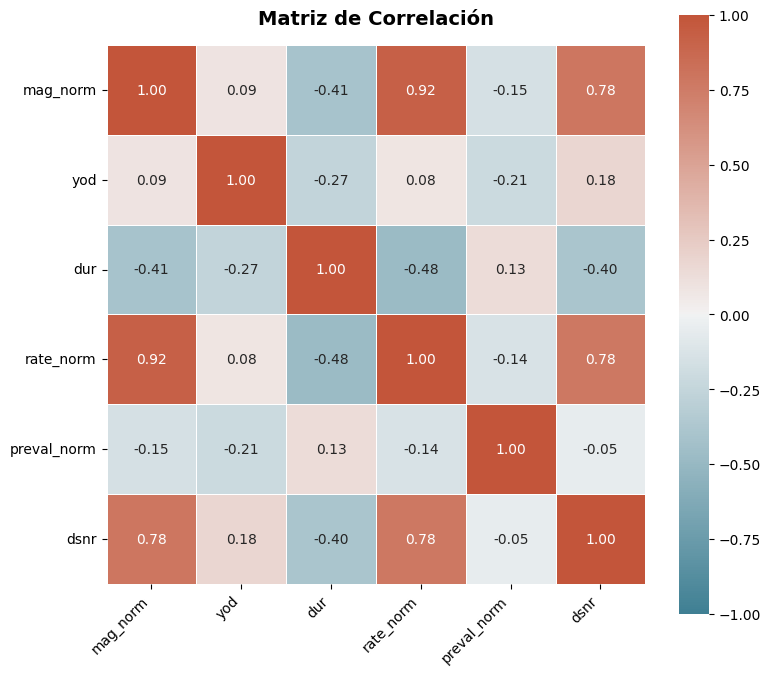

In [70]:
# Crear la matriz de correlación
matriz_corr = df[var_num].corr(numeric_only=True)

# Configurar la figura
plt.figure(figsize=(8, 8))  # Ajustar el tamaño de la figura

# Mapa de calor
sns.heatmap(
    matriz_corr,
    vmin=-1, vmax=1,  # Rango de valores
    cmap=sns.diverging_palette(220, 20, as_cmap=True),  # Paleta de colores divergentes
    square=True,  # Cuadrados perfectos
    linewidths=0.5,  # Grosor de las líneas entre celdas
    annot=True,  # Mostrar valores dentro de las celdas
    fmt=".2f",  # Formato de los números
    cbar_kws={"shrink": 0.8},  # Ajustar el tamaño de la barra de colores
)

# Configurar títulos y ejes
plt.title("Matriz de Correlación", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")  # Rotar etiquetas del eje x
plt.yticks(rotation=0)  # Mantener etiquetas del eje y horizontales

# Mostrar la figura
plt.tight_layout()
plt.show()




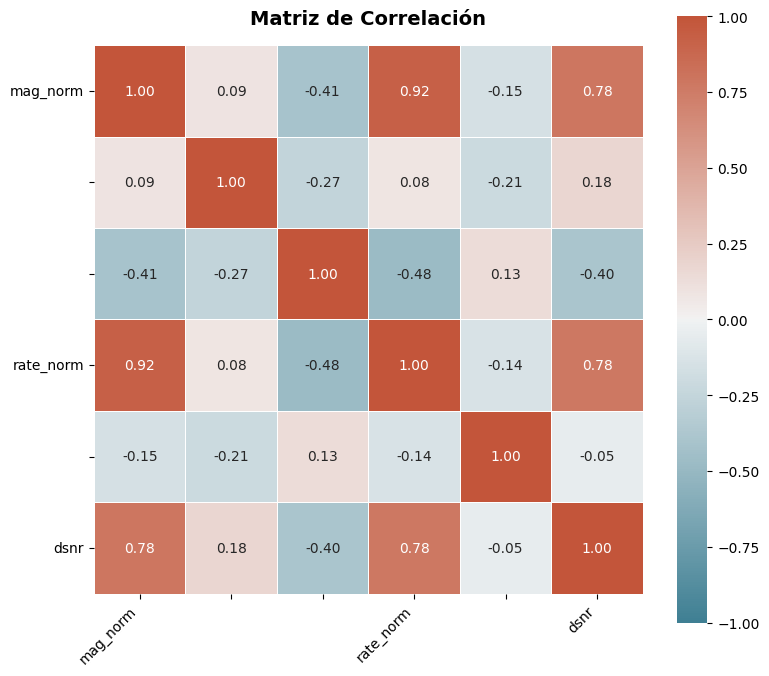

In [73]:
# ANÁLISIS DE CORRELACIÓN
matriz_corr = df[var_num].corr(numeric_only=True)

# Crear la figura
fig, ax = plt.subplots(figsize=(8, 8))

# Dibujar el heatmap completo
sns.heatmap(
    matriz_corr,
    vmin=-1, vmax=1,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8},
    ax=ax
)

# Definir las etiquetas que quieres mantener
variables_a_mostrar = ["mag_norm", "rate_norm", "dsnr"]

# Crear etiquetas manuales para los ticks
x_labels = [label if label in variables_a_mostrar else "" for label in matriz_corr.columns]
y_labels = [label if label in variables_a_mostrar else "" for label in matriz_corr.index]

# Actualizar los ticks manualmente
ax.set_xticks([i + 0.5 for i in range(len(x_labels))])  # Centrar los ticks
ax.set_xticklabels(x_labels, rotation=45, ha="right")

ax.set_yticks([i + 0.5 for i in range(len(y_labels))])  # Centrar los ticks
ax.set_yticklabels(y_labels, rotation=0)

# Título
plt.title("Matriz de Correlación", fontsize=14, fontweight="bold", pad=15)

# Ajustar diseño
plt.tight_layout()

# Mostrar la figura
plt.show()


* Alta correlación entre magntiud y rate, dado que la segunda se deriva de la primera. En desarrollo de modelos, no incluir ambas variables para evitar problemas de muticolinealidad

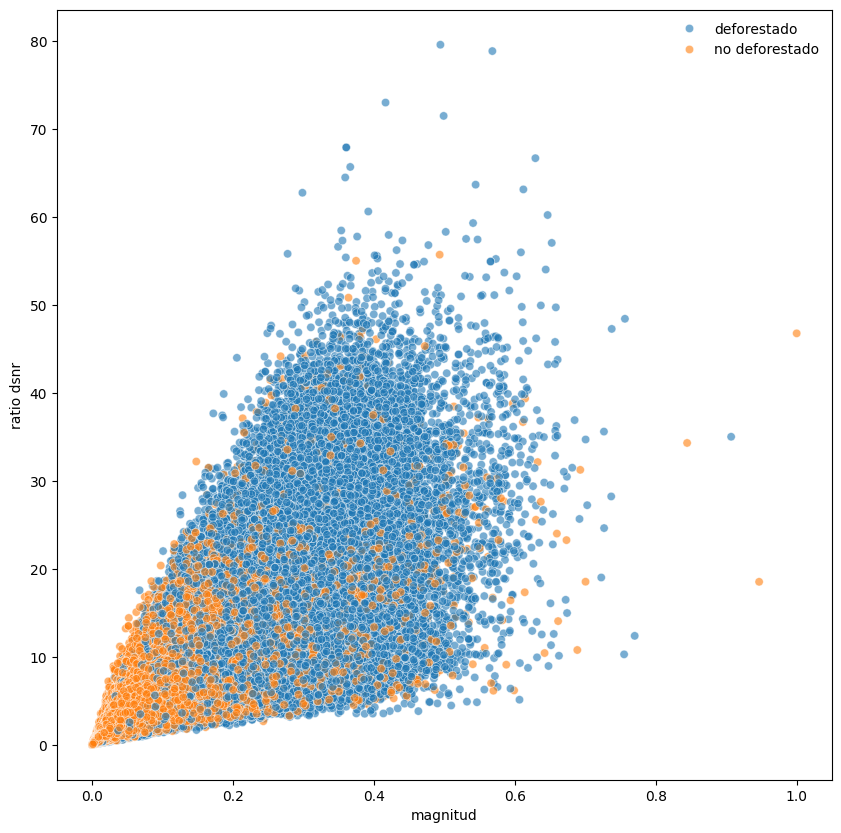

In [77]:
# ANÁLISIS DE PATRONES CON SCATTERPLOTS

# Crear la figura
plt.figure(figsize=(10, 10))

# Graficar el scatterplot
scatter = sns.scatterplot(
    x="mag_norm", 
    y="dsnr", 
    data=df, 
    hue="clasificacion_desc", 
    alpha=0.6
)

scatter.set_xlabel("magnitud")
scatter.set_ylabel("ratio dsnr")

# Eliminar el título de la leyenda
scatter.legend_.set_title(None)

# Eliminar el borde de la caja de la leyenda
scatter.legend_.get_frame().set_linewidth(0)  # Ancho de línea del borde a 0

# Mostrar el gráfico
plt.show()

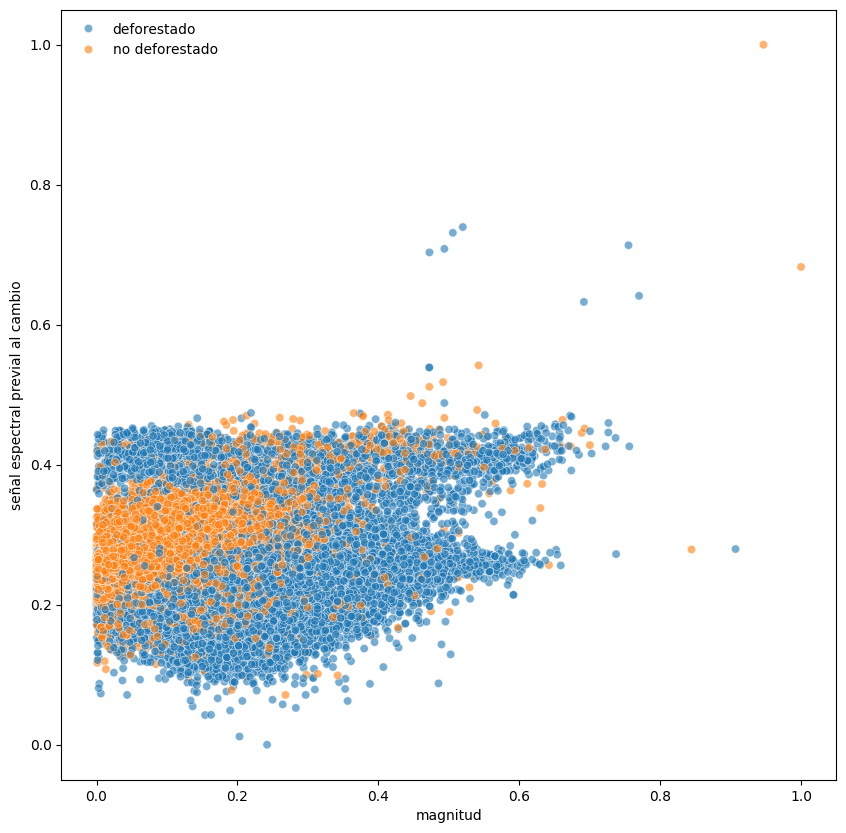

In [78]:
# Crear la figura
plt.figure(figsize=(10, 10))

# Graficar el scatterplot
scatter = sns.scatterplot(
    x="mag_norm", 
    y="preval_norm", 
    data=df,
    hue="clasificacion_desc", 
    alpha=0.6
)

scatter.set_xlabel("magnitud")
scatter.set_ylabel("señal espectral previal al cambio")

# Eliminar el título de la leyenda
scatter.legend_.set_title(None)

# Eliminar el borde de la caja de la leyenda
scatter.legend_.get_frame().set_linewidth(0)  # Ancho de línea del borde a 0

# Mostrar el gráfico
plt.show()

* Se identifican agrupaciones/patrones claros cuando los datos se representan en el espacio bidimensional formado por mag-dsnr y el espacio bidimensional mag-preval, pero las fronteras de decisión son complejas
* De cara al desarrollo del modelo, analizar las distribuciones log-normal de las variables para reducir el solapamiento entre las clases deforestado y no deforestado. Evaluar agrupaciones/patrones en espacio 3d definido por mag-dsnr-preval, así como evaluar incluir la variable que describa la señal espectral posterior al cambio que "teóricamente" debería generar más información sobre el evento de deforestación que el valor de la señal espectral previo al cambio